In [ ]:
reset

In [2]:
import xarray as xr
xr.set_options(keep_attrs=True)
import netCDF4 as nc
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import metpy.calc as mp
from metpy.units import units
from datetime import datetime

import seaborn as sns
import cartopy
cartopy.config['data_dir'] = "/discover/nobackup/projects/jh_tutorials/JH_examples/JH_datafiles/Cartopy"
cartopy.config['pre_existing_data_dir'] = "/discover/nobackup/projects/jh_tutorials/JH_examples/JH_datafiles/Cartopy"
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from shapely.geometry.polygon import LinearRing

from matplotlib import transforms
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mticker
from matplotlib import cm
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import cmocean
import cmocean.cm as cmo

# top level data directory
dpath0='/discover/nobackup/projects/giss/baldwin_nip/dmkumar'

In [2]:
### ---------------------------- ###
###            Inputs            ###
### ---------------------------- ###

# set lat/lon bounds
lat_min=-55
lat_max=25
lon_min=-95
lon_max=-50

# set atmospheric upper pressure level threshold
p1=1000 #hPa
p2=500 #hPa

In [7]:
### ---------------------------- ###
###      Process topo data       ###
### ---------------------------- ###
print('Processing ETOPO05 data...')
etopofile='obs.etopo5.zsurf.nc'
etopo_full=xr.open_dataset(f'{dpath0}/topo_files/{etopofile}').ROSE
etopo_full=etopo_full.where(etopo_full>=0,0) # replace bathymetry with surface height=0m
etopo_full=etopo_full.rename({'ETOPO05_Y':'lat', 'ETOPO05_X':'lon'}) # rename x & y coordinate names to match MERRA data
etopo_full=longitude_flip(etopo_full) # switch lons from 0:360 to -180:180

print('Clipping ETOPO05 data...')
# Clip etopo data to lat/lon bounds
etopo_clip=etopo_full.sel(lat=slice(lat_min,lat_max), lon=slice(lon_min,lon_max))

print('Loading E2.1 topography data...')
default=xr.open_dataset(f'{dpath0}/topo_files/Z2HX2fromZ1QX1N.BS1.nc').zatmo
maxtopo=xr.open_dataset(f'{dpath0}/topo_files/giss.maxtopo.cam.sam.nc').zatmo  
p80=xr.open_dataset(f'{dpath0}/topo_files/giss.80topo.cam.sam.nc').zatmo
p85=xr.open_dataset(f'{dpath0}/topo_files/giss.85topo.cam.sam.nc').zatmo
cs1pt5env=xr.open_dataset(f'{dpath0}/topo_files/giss.1.5s-env.topo.cam.sam.nc').zatmo
cs1env=xr.open_dataset(f'{dpath0}/topo_files/giss.1s-env.topo.cam.sam.nc').zatmo
c1env=xr.open_dataset(f'{dpath0}/topo_files/giss.1s-env.topo.cam_only.nc').zatmo  
## create matrix of topo bcs
default=default.assign_coords(source_id='CTRL')
maxtopo=maxtopo.assign_coords(source_id='MAX')
p85=p85.assign_coords(source_id='P$_{85}$')
p80=p80.assign_coords(source_id='P$_{80}$')
cs1pt5env=cs1pt5env.assign_coords(source_id='1.5$\sigma$ENV')
cs1env=cs1env.assign_coords(source_id='1$\sigma$ENV')
c1env=c1env.assign_coords(source_id='1$\sigma$ENV-CAM')
modTopo=xr.concat([default,maxtopo,p85,p80,cs1pt5env,cs1env,c1env],dim='source_id')

print('Done.')

Processing ETOPO05 data...
Clipping ETOPO05 data...
Loading E2.1 topography data...
Done.


In [8]:
## Load Output
# Obs Froude
frObs=xr.open_dataset(f'{dpath0}/obs_data/froude.etopo05.nc').froude
# E2.1 Froude
frGiss=xr.open_dataset(f'{dpath0}/output/froude.e2.1.topo.nc').froude
# E2.1 Ocean Mask
ocn_mask=xr.open_dataset(f'{dpath0}/topo_files/Z2HX2fromZ1QX1N.BS1.nc').fgrnd.sel(lat=slice(-55,25), lon=slice(-110,-60))

In [9]:
## Regrid & index Model Froude
# regrid model froude values to E2.1 grid
frGiss_lowres=frGiss.interp(lat=modTopo.lat, lon=modTopo.lon).sel(lat=slice(-55,25), lon=slice(-110,-60))
# keep only Froude values above critical value (>1)
ones=xr.ones_like(frGiss_lowres)
frGiss_idx=frGiss_lowres.where(frGiss_lowres>=1, np.nan)
# mask ocean cells
frGiss_idx=frGiss_idx.where(ocn_mask>0.25,np.nan)
frGiss_lowres=frGiss_lowres.where(ocn_mask>0.25,np.nan)
## Index Obs Froude
# keep only Froude values above critical value (>1)
ones=xr.ones_like(frObs)
frObs_idx=frObs.where(frObs>=1, np.nan)

#### Calculate Froude from Upstream Vars and Save Output

In [23]:
def windSpd(u,v):
   windSpd=np.sqrt(u**2 + v**2)
   return windSpd

def froude(N,h,Uspd):
   fr=(N*h)/Uspd
   return fr

def froude_from_upstream_vars(topo,u,v,ts,ta,z,
                              p2wind=800,
                              p2n=600,
                              oro_lat_bounds=None,
                              oro_lon_bounds=None,
                              ups_lat_bounds=None,
                              ups_lon_bounds=None):
    ## Clip topo data to corresponding lat/lon bounds
    print('Clipping topography...')
    tymin=oro_lat_bounds[0] ; tymax=oro_lat_bounds[1]
    txmin=oro_lon_bounds[0] ; txmax=oro_lon_bounds[1]
    h=topo.sel(lat=slice(tymin,tymax), lon=slice(txmin,txmax))
    
    ## Define pressure level thresholds for wind and N vars
    surface_plev=1000
    wind_p2lev=p2wind
    wind_p2idx=int(np.where(u.lev==wind_p2lev)[0])
    n_p2lev=p2n
    n_p2idx=int(np.where(u.lev==n_p2lev)[0])

    ## Clip upstream climate data and calculate zonal regional means
    print('Calculating Zonal Mean Upstream Uspd...')
    ymin=ups_lat_bounds[0] ; ymax=ups_lat_bounds[1]
    xmin=ups_lon_bounds[0] ; xmax=ups_lon_bounds[1]
    # Wind Speed
    uwnd=u[:,0:wind_p2idx,:,:].sel(lat=slice(ymin,ymax), lon=slice(xmin,xmax))
    vwnd=v[:,0:wind_p2idx,:,:].sel(lat=slice(ymin,ymax), lon=slice(xmin,xmax))
    Uspd=windSpd(uwnd,vwnd).mean(dim=['lev','lon'])
    # Buoyancy Frequency
    print('Calculating Zonal Mean Upstream N...')
    t0=ts.sel(lat=slice(ymin,ymax), lon=slice(xmin,xmax))
    t1=ta[:,n_p2idx,:,:].sel(lat=slice(ymin,ymax), lon=slice(xmin,xmax))
    z0=topo.sel(lat=slice(ymin,ymax), lon=slice(xmin,xmax)) # get surface height from etopo dataset
    z1=z[:,n_p2idx,:,:].sel(lat=slice(ymin,ymax), lon=slice(xmin,xmax)) # height of atm at plevel
    g=np.full((len(t0.lat),len(t0.lon)), 9.81) # gravity
    theta=t1*((surface_plev/p1)**(2/7))
    dtdz=(t1-t0)/(z1-z0)
    dthetadz=((surface_plev/p1)**(2/7)) * (.00976 - np.abs(dtdz))
    N=np.sqrt((g/theta)*dthetadz).mean(dim='lon',skipna=True)
    
    ## Calculate Froude
    print('Calculating Froude...')
    Fr=froude(N,h,Uspd)
    print('Done.')
    return(Fr)

In [3]:
## Load MERRA-2 Climate Data
frvars=xr.open_dataset(f'{dpath0}/obs_data/frvars.climo.nc')

In [35]:
### ----------------------------------------- ###
###    Calculate Model Froude with E2.1 BCs   ###
### ----------------------------------------- ###

modTopo_etopo_grid=modTopo.interp(lat=etopo_full.lat, lon=etopo_full.lon)

f1 = froude_from_upstream_vars(modTopo_etopo_grid,frvars.u,frvars.v,frvars.ts,frvars.ta,frvars.h,
                               p2wind=800, p2n=600,
                               oro_lat_bounds=[-55,-30], oro_lon_bounds=[-80,-60],
                               ups_lat_bounds=[-55,-30], ups_lon_bounds=[-95,-90])

f2 = froude_from_upstream_vars(modTopo_etopo_grid,frvars.u,frvars.v,frvars.ts,frvars.ta,frvars.h,
                               p2wind=800, p2n=600,
                               oro_lat_bounds=[-29.99,-10], oro_lon_bounds=[-80,-60],
                               ups_lat_bounds=[-29.99,-10], ups_lon_bounds=[-55,-50])

f3 = froude_from_upstream_vars(modTopo_etopo_grid,frvars.u,frvars.v,frvars.ts,frvars.ta,frvars.h,
                               p2wind=800, p2n=600,
                               oro_lat_bounds=[-9.99,11], oro_lon_bounds=[-90,-69],
                               ups_lat_bounds=[-9.99,11], ups_lon_bounds=[-65,-60])

f4 = froude_from_upstream_vars(modTopo_etopo_grid,frvars.u,frvars.v,frvars.ts,frvars.ta,frvars.h,
                               p2wind=800, p2n=600,
                               oro_lat_bounds=[11.01,25], oro_lon_bounds=[-110,-80],
                               ups_lat_bounds=[11.01,25], ups_lon_bounds=[-75,-70])

frGiss=xr.concat([f1,f2,f3,f4], dim='lat', coords='minimal')
frGiss=frGiss.transpose('source_id','month','lat','lon')
frGiss=frGiss.where(frGiss>0, np.nan)
frGiss.attrs['long_name']='Froude'
frGiss.attrs['wind_levels']='1000-800hPa'
frGiss.attrs['N_levels']='1000-600hPa'
del frGiss.attrs['units']

# make netcdf
month=frGiss.month
source_id=frGiss.source_id
lat=frGiss.lat
lon=frGiss.lon
frGiss=xr.Dataset(data_vars=dict(froude=(['source_id','month','lat','lon'], frGiss.data, frGiss.attrs),),
                  coords=dict(source_id=source_id,month=month,lat=lat,lon=lon,),)
frGiss.to_netcdf(f'{dpath0}/output/froude.e2.1.topo.nc', mode='w')

Clipping topography...
Calculating Zonal Mean Upstream Uspd...
Calculating Zonal Mean Upstream N...


/gpfsm/dnb33/tdirs/batch/slurm.26075600.dmkumar/ipykernel_28063/1226328961.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  wind_p2idx=int(np.where(u.lev==wind_p2lev)[0])
/gpfsm/dnb33/tdirs/batch/slurm.26075600.dmkumar/ipykernel_28063/1226328961.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  n_p2idx=int(np.where(u.lev==n_p2lev)[0])


Calculating Froude...
Done.
Clipping topography...
Calculating Zonal Mean Upstream Uspd...
Calculating Zonal Mean Upstream N...
Calculating Froude...
Done.
Clipping topography...
Calculating Zonal Mean Upstream Uspd...


/gpfsm/dnb33/tdirs/batch/slurm.26075600.dmkumar/ipykernel_28063/1226328961.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  wind_p2idx=int(np.where(u.lev==wind_p2lev)[0])
/gpfsm/dnb33/tdirs/batch/slurm.26075600.dmkumar/ipykernel_28063/1226328961.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  n_p2idx=int(np.where(u.lev==n_p2lev)[0])
/gpfsm/dnb33/tdirs/batch/slurm.26075600.dmkumar/ipykernel_28063/1226328961.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

Calculating Zonal Mean Upstream N...
Calculating Froude...
Done.
Clipping topography...
Calculating Zonal Mean Upstream Uspd...
Calculating Zonal Mean Upstream N...
Calculating Froude...


/gpfsm/dnb33/tdirs/batch/slurm.26075600.dmkumar/ipykernel_28063/1226328961.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  wind_p2idx=int(np.where(u.lev==wind_p2lev)[0])
/gpfsm/dnb33/tdirs/batch/slurm.26075600.dmkumar/ipykernel_28063/1226328961.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  n_p2idx=int(np.where(u.lev==n_p2lev)[0])


Done.


In [39]:
### ----------------------------------------- ###
###  Calculate Observed Froude from ETOPO Obs ###
### ----------------------------------------- ###

f1 = froude_from_upstream_vars(etopo_full,frvars.u,frvars.v,frvars.ts,frvars.ta,frvars.h,
                               p2wind=800, p2n=600,
                               oro_lat_bounds=[-55,-30], oro_lon_bounds=[-80,-60],
                               ups_lat_bounds=[-55,-30], ups_lon_bounds=[-95,-90])

f2 = froude_from_upstream_vars(etopo_full,frvars.u,frvars.v,frvars.ts,frvars.ta,frvars.h,
                               p2wind=800, p2n=600,
                               oro_lat_bounds=[-29.99,-10], oro_lon_bounds=[-80,-60],
                               ups_lat_bounds=[-29.99,-10], ups_lon_bounds=[-55,-50])

f3 = froude_from_upstream_vars(etopo_full,frvars.u,frvars.v,frvars.ts,frvars.ta,frvars.h,
                               p2wind=800, p2n=600,
                               oro_lat_bounds=[-9.99,11], oro_lon_bounds=[-90,-69],
                               ups_lat_bounds=[-9.99,11], ups_lon_bounds=[-65,-60])

f4 = froude_from_upstream_vars(etopo_full,frvars.u,frvars.v,frvars.ts,frvars.ta,frvars.h,
                               p2wind=800, p2n=600,
                               oro_lat_bounds=[11.01,25], oro_lon_bounds=[-110,-80],
                               ups_lat_bounds=[11.01,25], ups_lon_bounds=[-75,-70])

frObs=xr.concat([f1,f2,f3,f4], dim='lat', coords='minimal')
frObs=frObs.where(frObs>0, np.nan)
frObs.attrs['long_name']='Froude'
frObs.attrs['wind_levels']='1000-800hPa'
frObs.attrs['N_levels']='1000-600hPa'
del frObs.attrs['units']

# make netcdf
month=frObs.month
lat=frObs.lat
lon=frObs.lon
frObs=xr.Dataset(data_vars=dict(froude=(['month','lat','lon'], frObs.data, frObs.attrs),),
                  coords=dict(month=month,lat=lat,lon=lon,),)
frObs.to_netcdf(f'{dpath0}/obs_data/froude.etopo05.nc', mode='w')

Clipping topography...
Calculating Zonal Mean Upstream Uspd...
Calculating Zonal Mean Upstream N...
Calculating Froude...
Done.
Clipping topography...
Calculating Zonal Mean Upstream Uspd...
Calculating Zonal Mean Upstream N...
Calculating Froude...
Done.
Clipping topography...
Calculating Zonal Mean Upstream Uspd...
Calculating Zonal Mean Upstream N...


/gpfsm/dnb33/tdirs/batch/slurm.26075600.dmkumar/ipykernel_28063/1226328961.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  wind_p2idx=int(np.where(u.lev==wind_p2lev)[0])
/gpfsm/dnb33/tdirs/batch/slurm.26075600.dmkumar/ipykernel_28063/1226328961.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  n_p2idx=int(np.where(u.lev==n_p2lev)[0])
/gpfsm/dnb33/tdirs/batch/slurm.26075600.dmkumar/ipykernel_28063/1226328961.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

Calculating Froude...
Done.
Clipping topography...
Calculating Zonal Mean Upstream Uspd...
Calculating Zonal Mean Upstream N...
Calculating Froude...
Done.


/gpfsm/dnb33/tdirs/batch/slurm.26075600.dmkumar/ipykernel_28063/1226328961.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  wind_p2idx=int(np.where(u.lev==wind_p2lev)[0])
/gpfsm/dnb33/tdirs/batch/slurm.26075600.dmkumar/ipykernel_28063/1226328961.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  n_p2idx=int(np.where(u.lev==n_p2lev)[0])


#### Plot Froude on ETOPO grid

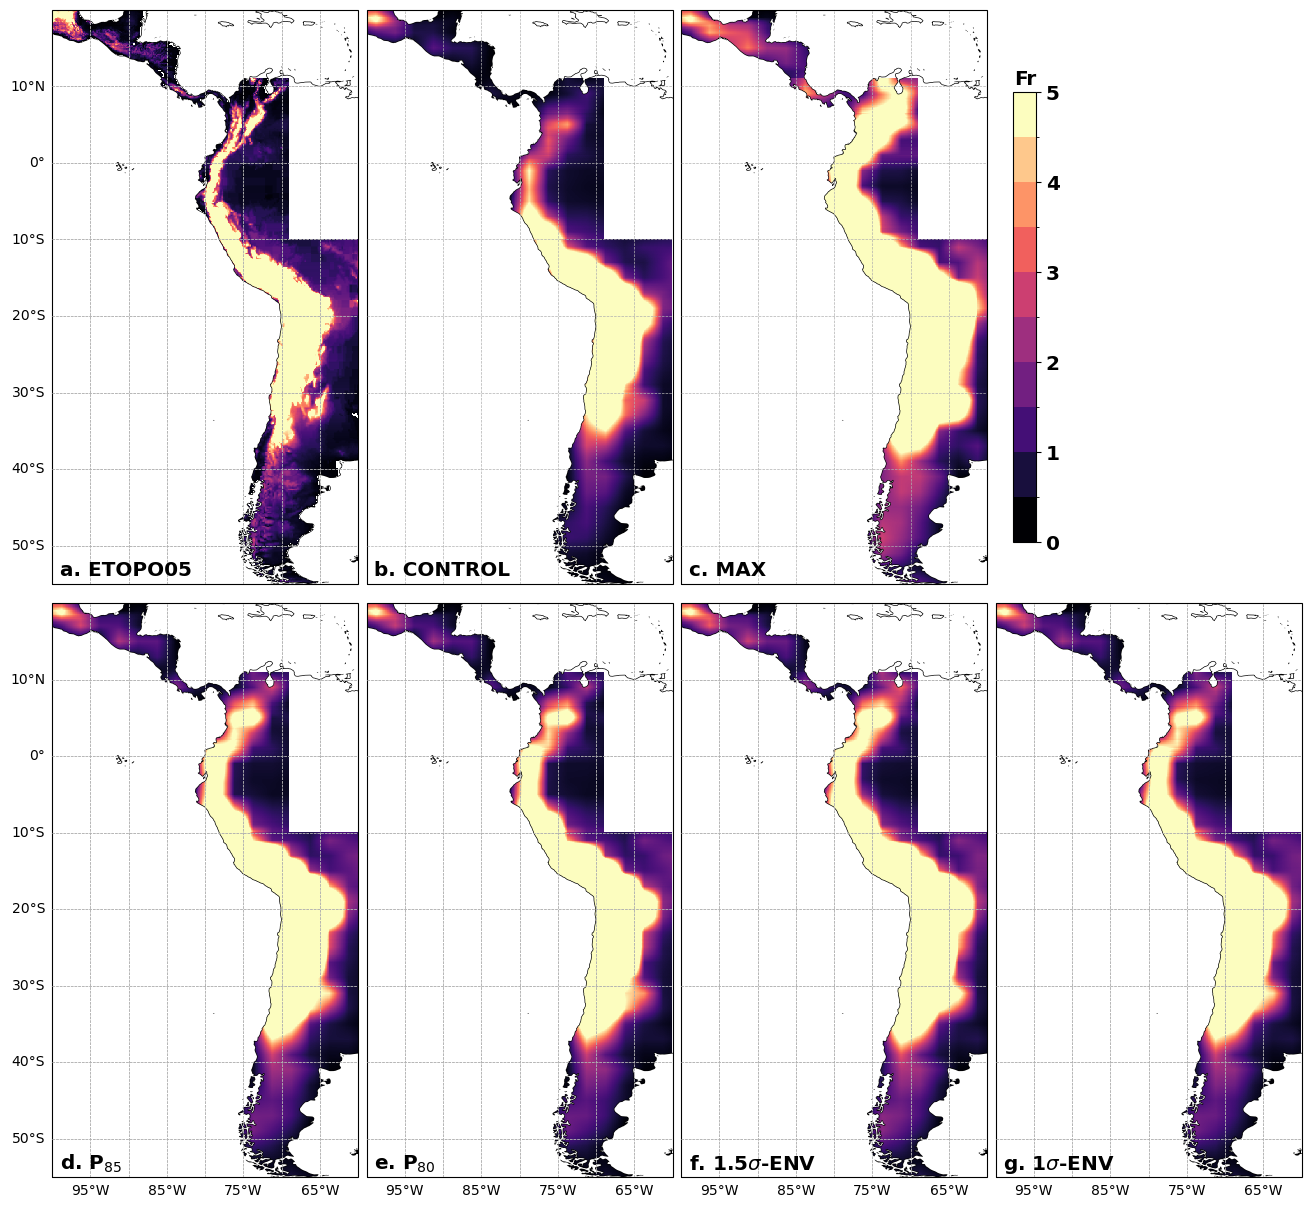

In [254]:
text_kw={'color':'k', 'weight':'bold', 'size':'x-large', 'horizontalalignment':'left'}
cmap=cm.magma
vmin=0
vmax=5
trans=ccrs.PlateCarree()
proj=ccrs.PlateCarree()
map_bnds=[-100,-60,-55,20]
titles=[]

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(13,12), layout='constrained', subplot_kw={'projection':proj})

ax[0,0].text(-99,-54,'a. ETOPO05',**text_kw,zorder=100)
ax[0,0].pcolormesh(frObs.lon, frObs.lat, frObs.mean(dim='month'), cmap=cmap, vmin=vmin, vmax=vmax, transform=trans)
gl=ax[0,0].gridlines(crs=trans, lw=.5, colors='black', alpha=1.0, linestyle='--', zorder=10, draw_labels=True)
gl.bottom_labels=False; gl.left_labels=True; gl.top_labels=False; gl.right_labels=False

ax[0,1].text(-99,-54,'b. '+str(frGiss[0].source_id.values),**text_kw,zorder=100)
ax[0,1].pcolormesh(frGiss.lon, frGiss.lat, frGiss[0].mean(dim='month'), cmap=cmap, vmin=vmin, vmax=vmax, transform=trans)

ax[0,2].text(-99,-54,'c. '+str(frGiss[1].source_id.values),**text_kw,zorder=100)
ax[0,2].pcolormesh(frGiss.lon, frGiss.lat, frGiss[1].mean(dim='month'), cmap=cmap, vmin=vmin, vmax=vmax, transform=trans)

ax[0,3].set_visible(False)

ax[1,0].text(-99,-54,'d. '+str(frGiss[2].source_id.values),**text_kw,zorder=100)
ax[1,0].pcolormesh(frGiss.lon, frGiss.lat, frGiss[2].mean(dim='month'), cmap=cmap, vmin=vmin, vmax=vmax, transform=trans)
gl=ax[1,0].gridlines(crs=trans, lw=.5, colors='black', alpha=1.0, linestyle='--', zorder=10, draw_labels=True)
gl.bottom_labels=True; gl.left_labels=True; gl.top_labels=False; gl.right_labels=False

ax[1,1].text(-99,-54,'e. '+str(frGiss[3].source_id.values),**text_kw,zorder=100)
ax[1,1].pcolormesh(frGiss.lon, frGiss.lat, frGiss[3].mean(dim='month'), cmap=cmap, vmin=vmin, vmax=vmax, transform=trans)
gl=ax[1,1].gridlines(crs=trans, lw=.5, colors='black', alpha=1.0, linestyle='--', zorder=10, draw_labels=True)
gl.bottom_labels=True; gl.left_labels=False; gl.top_labels=False; gl.right_labels=False

ax[1,2].text(-99,-54,'f. '+str(frGiss[4].source_id.values),**text_kw,zorder=100)
ax[1,2].pcolormesh(frGiss.lon, frGiss.lat, frGiss[4].mean(dim='month'), cmap=cmap, vmin=vmin, vmax=vmax, transform=trans)
gl=ax[1,2].gridlines(crs=trans, lw=.5, colors='black', alpha=1.0, linestyle='--', zorder=10, draw_labels=True)
gl.bottom_labels=True; gl.left_labels=False; gl.top_labels=False; gl.right_labels=False

ax[1,3].text(-99,-54,'g. '+str(frGiss[5].source_id.values),**text_kw,zorder=100)
ax[1,3].pcolormesh(frGiss.lon, frGiss.lat, frGiss[5].mean(dim='month'), cmap=cmap, vmin=vmin, vmax=vmax, transform=trans)
gl=ax[1,3].gridlines(crs=trans, lw=.5, colors='black', alpha=1.0, linestyle='--', zorder=10, draw_labels=True)
gl.bottom_labels=True; gl.left_labels=False; gl.top_labels=False; gl.right_labels=False

for i, ax in enumerate(ax.flat): 
    ax.coastlines()
    ax.add_feature(cfeature.OCEAN, fc=(1, 1, 1), zorder=2)
    ax.set_extent(map_bnds, crs=trans)
    ax.gridlines(crs=trans, lw=.5, colors='black', alpha=1.0, linestyle='--', zorder=10, draw_labels=False)

# add colorbar
levels=np.linspace(vmin, vmax, 11)
norm=mpl.colors.BoundaryNorm(levels, cmap.N)
cf=mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
cax=fig.add_axes([0.775, 0.55, 0.0175, 0.375])
cbar=fig.colorbar(cf, orientation='vertical', cax=cax)
cbar.set_label('Fr', y=1.05, labelpad=-25, rotation=0, size='x-large', fontweight='bold', ha='center')
cbar.ax.tick_params(labelsize='x-large')
for tick in cbar.ax.yaxis.get_major_ticks():
    tick.label2.set_fontweight('bold')
    
plt.savefig('figs/froude.pdf', transparent=True, bbox_inches='tight')

# Plot Topography

In [11]:
ymin=-55
ymax=20
xmin=-98
xmax=-60
modTopo_zm=modTopo.sel(lat=slice(ymin,ymax), lon=slice(xmin,xmax)).max(dim="lon",skipna=True)
etopo_zm=etopo_full.sel(lat=slice(ymin,ymax), lon=slice(xmin,xmax)).max(dim="lon",skipna=True)

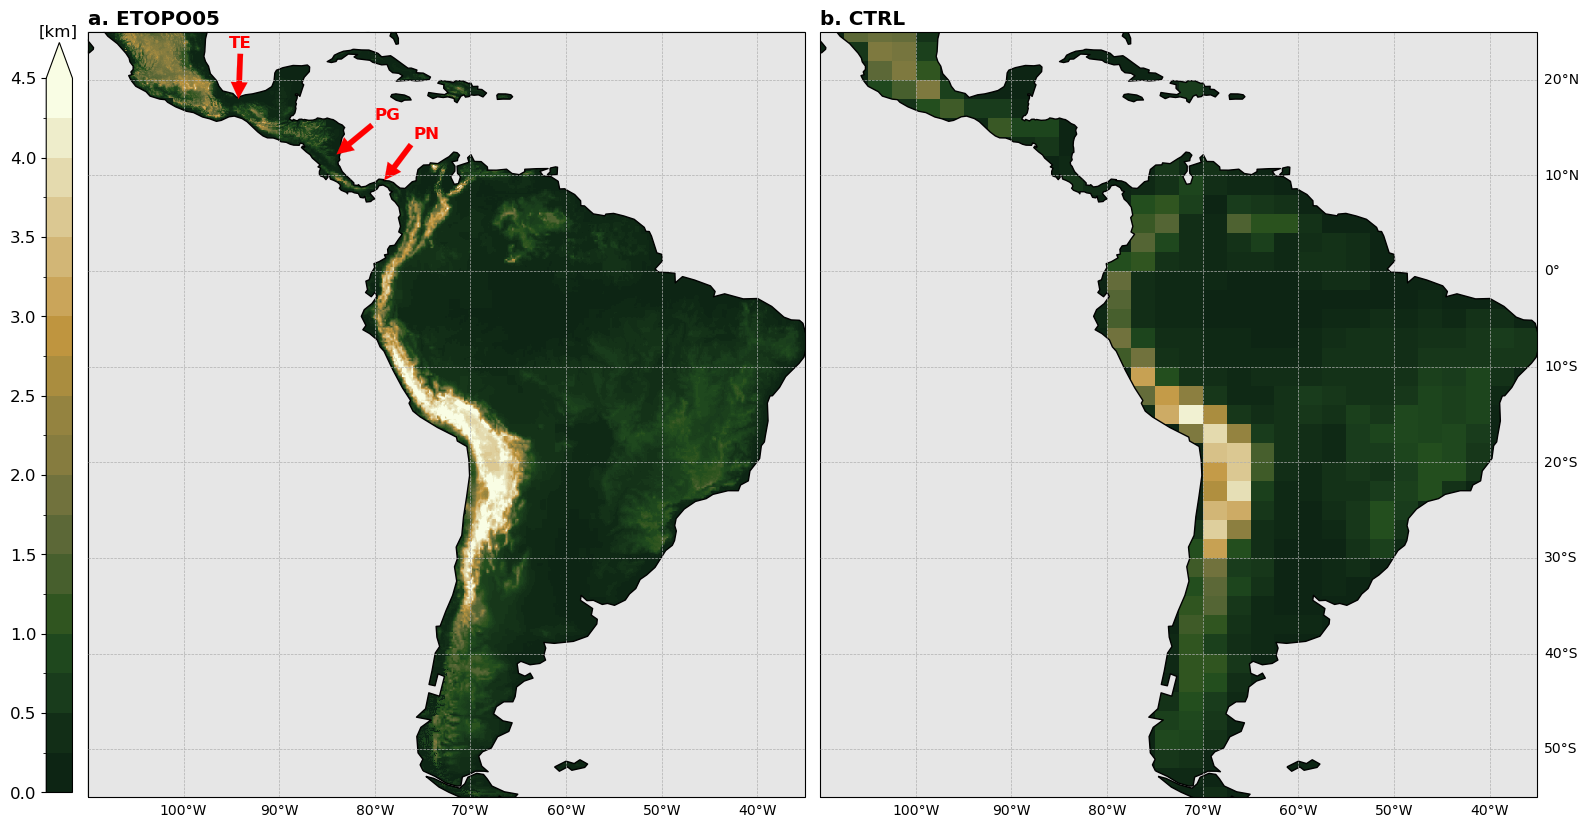

In [21]:
colors=['silver','darkcyan','darkgreen','limegreen','olive','gold']
tkw = {'axis': 'both', 'direction':'in', 'labelsize': 'large', 'labelcolor': 'k'}   
text_kw={'color':'k', 'weight':'bold', 'size':'x-large', 'ha':'center'}
arrow_kw={'color':'red', 'linewidth':.1, 'shrink':0.0}
line_kw={'ls':'-', 'lw':3, 'drawstyle':'steps-pre'} 
patch_kw = {'facecolor':'grey', 'alpha':0.25}
legend_kw={'fontsize':'large', 'ncols':1, 'labelcolor':'linecolor', 'frameon':True}
# map specs
trans=ccrs.PlateCarree()
proj=ccrs.PlateCarree()
map_bnds = [-110., -35., -55., 25.]
lon_bnds = np.array([-98., -75, -75, -98.])
lat_bnds = np.array([18,  18,  5,  5])

# colormap specs
cmap=ListedColormap(cmo.topo(np.linspace(0.5,1.0)))
cmap.set_under('white', 1.0)
vmin=0.
vmax=4.5
levels=np.linspace(0,vmax,19)
norm=mpl.colors.BoundaryNorm(levels, cmap.N)

fig=plt.figure(figsize=(15,12), layout='constrained') 

## Topo Maps
ax=plt.subplot2grid((1, 2), (0, 0), colspan=1, rowspan=2, projection=proj)
#ax.text(-110, 25.75, 'b. Observed and E2.1 Control Topography', weight='bold', size='x-large', horizontalalignment='left')
#ax.text(-109, -54, 'ETOPO05', weight='bold', size=18, horizontalalignment='left')
ax.text(-110, 25.75, 'a. ETOPO05', weight='bold', size='x-large', horizontalalignment='left')
ax.pcolormesh(etopo_full.lon, etopo_full.lat, etopo_full/1000, cmap=cmap, vmin=vmin, vmax=vmax, transform=trans, zorder=1)
ax.annotate('TE', xy=(-94.25,18), xytext=(-95.25,23), label='_Hidden', arrowprops=arrow_kw, color='r', weight='bold', size='large', ha='left', va='bottom', zorder=10)
ax.annotate('PG', xy=(-84,12.2), xytext=(-80,15.5), label='_Hidden', arrowprops=arrow_kw, color='r', weight='bold', size='large', ha='left', va='bottom', zorder=10)
ax.annotate('PN', xy=(-79,9.5), xytext=(-76,13.5), label='_Hidden', arrowprops=arrow_kw, color='r', weight='bold', size='large', ha='left', va='bottom', zorder=10)
ax.coastlines(zorder=3)
ax.add_feature(cfeature.OCEAN, fc=(0.9, 0.9, 0.9), zorder=2)
ax.set_extent(map_bnds, crs=trans)
gl=ax.gridlines(crs=trans, lw=.5, colors='black', alpha=1.0, linestyle='--', zorder=10, draw_labels=True)
#gl.xlocator=mticker.FixedLocator([-100,-90,-80,-70])
gl.bottom_labels=True; gl.left_labels=False; gl.top_labels=False; gl.right_labels=False
#ring=LinearRing(list(zip(lon_bnds, lat_bnds)))
#ax.add_geometries([ring], crs=trans, fc='none', ec='k', lw=1, linestyle='--', zorder=9)

ax=plt.subplot2grid((1, 2), (0, 1), colspan=1, rowspan=2, projection=proj)
ax.text(-110, 25.75, 'b. CTRL', weight='bold', size='x-large', horizontalalignment='left')
#ax.text(-109, -54, 'CTRL', weight='bold', size=18, horizontalalignment='left')
ax.pcolormesh(modTopo.lon, modTopo.lat, modTopo[0]/1000, cmap=cmap, vmin=vmin, vmax=vmax, transform=trans, zorder=2)
ax.coastlines(zorder=3)
ax.add_feature(cfeature.OCEAN, fc=(0.9, 0.9, 0.9), zorder=2)
ax.set_extent(map_bnds, crs=trans)
gl=ax.gridlines(crs=trans, lw=.5, colors='black', alpha=1.0, linestyle='--', zorder=10, draw_labels=True)
#gl.xlocator=mticker.FixedLocator([-100,-90,-80,-70])
gl.bottom_labels=True; gl.left_labels=False; gl.top_labels=False; gl.right_labels=True

## Colorbar
cax=fig.add_axes([-0.025, 0.185, 0.0175, 0.625])
cbar=fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), orientation='vertical', extend='max', cax=cax)
cbar.set_label('[km]', y=1.075, labelpad=-10, rotation=0, size='large', ha='center')
cbar.ax.tick_params(labelsize='large')
#for tick in cbar.ax.yaxis.get_major_ticks():
#    tick.label1.set_fontweight('bold')
cbar.ax.yaxis.set_ticks_position('left') 


plt.savefig('figs/topo_maps.png', format='png', transparent=True, bbox_inches='tight')

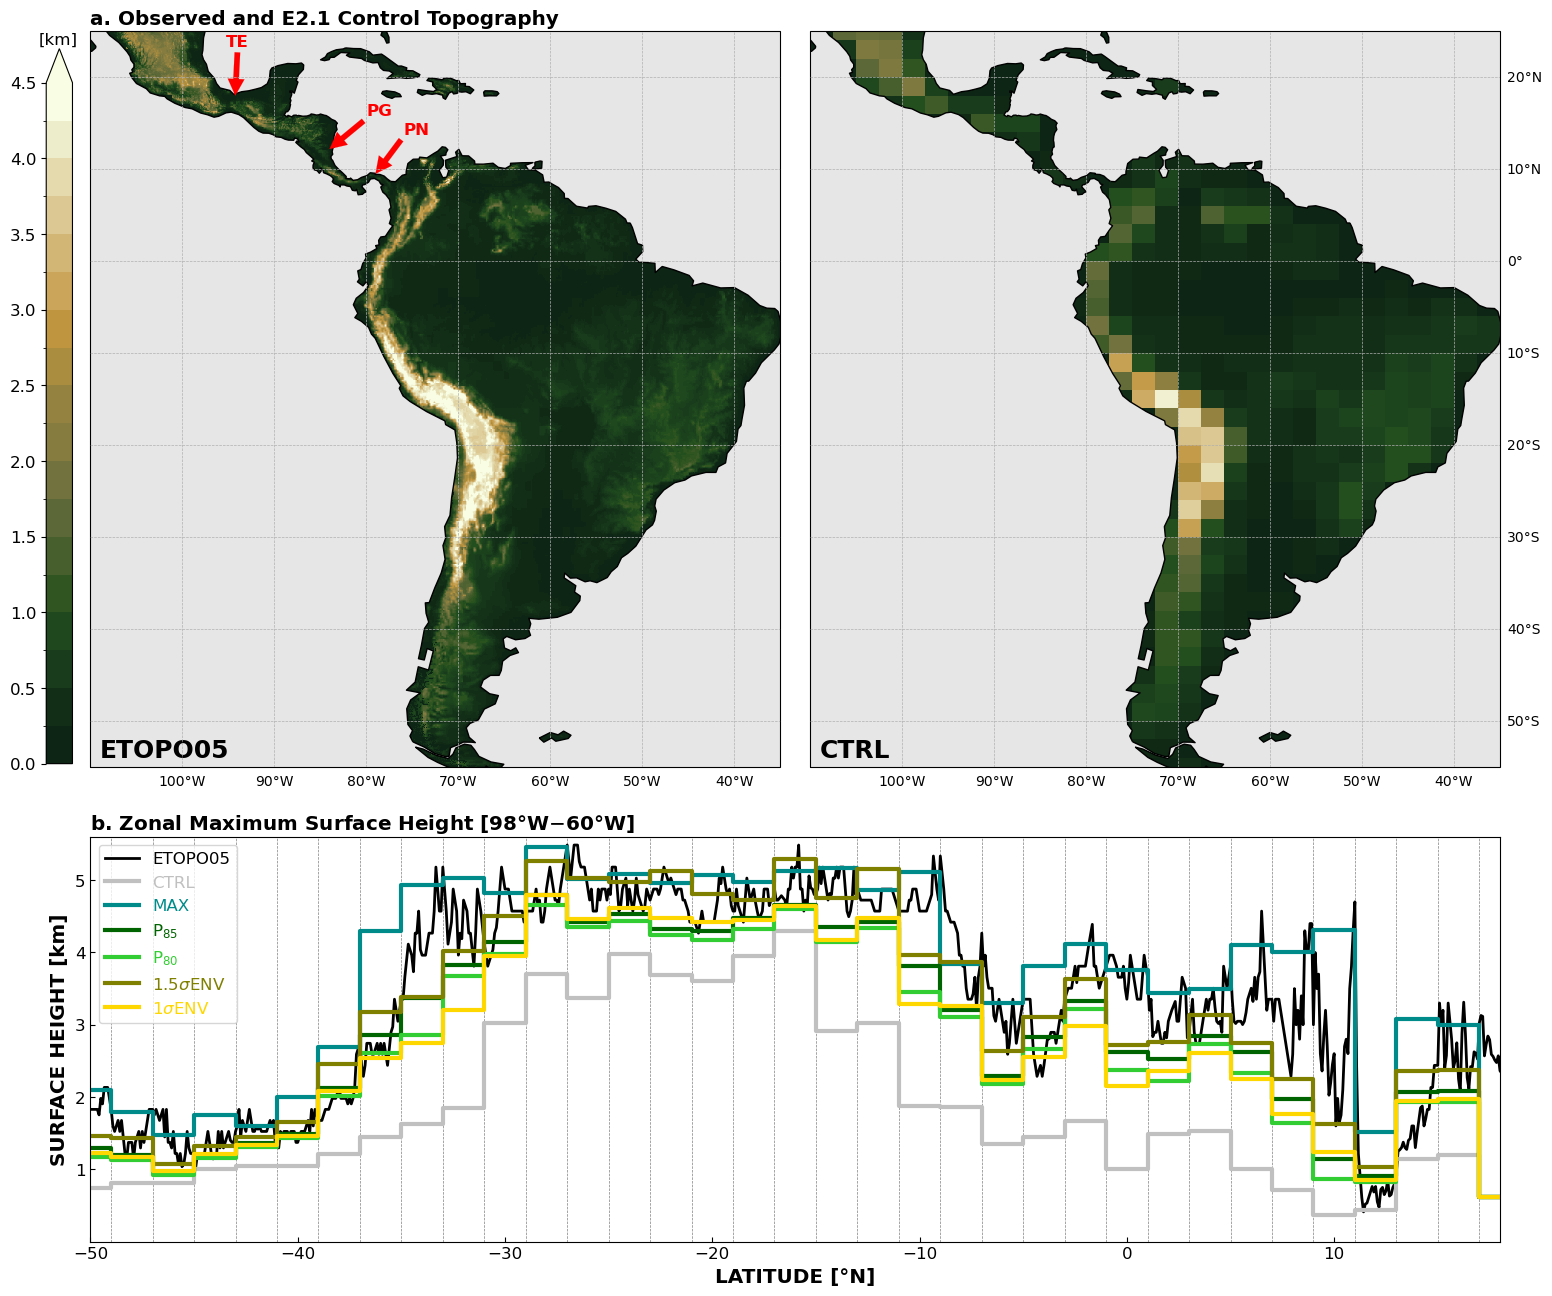

In [13]:
colors=['silver','darkcyan','darkgreen','limegreen','olive','gold']
tkw = {'axis': 'both', 'direction':'in', 'labelsize': 'large', 'labelcolor': 'k'}   
text_kw={'color':'k', 'weight':'bold', 'size':'x-large', 'ha':'center'}
arrow_kw={'color':'red', 'linewidth':.1, 'shrink':0.0}
line_kw={'ls':'-', 'lw':3, 'drawstyle':'steps-pre'} 
patch_kw = {'facecolor':'grey', 'alpha':0.25}
legend_kw={'fontsize':'large', 'ncols':1, 'labelcolor':'linecolor', 'frameon':True}
# map specs
trans=ccrs.PlateCarree()
proj=ccrs.PlateCarree()
map_bnds = [-110., -35., -55., 25.]
lon_bnds = np.array([-98., -75, -75, -98.])
lat_bnds = np.array([18,  18,  5,  5])

# colormap specs
cmap=ListedColormap(cmo.topo(np.linspace(0.5,1.0)))
cmap.set_under('white', 1.0)
vmin=0.
vmax=4.5
levels=np.linspace(0,vmax,19)
norm=mpl.colors.BoundaryNorm(levels, cmap.N)

fig=plt.figure(figsize=(15,13), layout='constrained')



## Topo Maps
ax=plt.subplot2grid((3, 2), (0, 0), colspan=1, rowspan=2, projection=proj)
ax.text(-110, 25.75, 'a. Observed and E2.1 Control Topography', weight='bold', size='x-large', horizontalalignment='left')
ax.text(-109, -54, 'ETOPO05', weight='bold', size=18, horizontalalignment='left')
ax.pcolormesh(etopo_full.lon, etopo_full.lat, etopo_full/1000, cmap=cmap, vmin=vmin, vmax=vmax, transform=trans, zorder=1)
ax.annotate('TE', xy=(-94.25,18), xytext=(-95.25,23), label='_Hidden', arrowprops=arrow_kw, color='r', weight='bold', size='large', ha='left', va='bottom', zorder=10)
ax.annotate('PG', xy=(-84,12.2), xytext=(-80,15.5), label='_Hidden', arrowprops=arrow_kw, color='r', weight='bold', size='large', ha='left', va='bottom', zorder=10)
ax.annotate('PN', xy=(-79,9.5), xytext=(-76,13.5), label='_Hidden', arrowprops=arrow_kw, color='r', weight='bold', size='large', ha='left', va='bottom', zorder=10)
ax.coastlines(zorder=3)
ax.add_feature(cfeature.OCEAN, fc=(0.9, 0.9, 0.9), zorder=2)
ax.set_extent(map_bnds, crs=trans)
gl=ax.gridlines(crs=trans, lw=.5, colors='black', alpha=1.0, linestyle='--', zorder=10, draw_labels=True)
#gl.xlocator=mticker.FixedLocator([-100,-90,-80,-70])
gl.bottom_labels=True; gl.left_labels=False; gl.top_labels=False; gl.right_labels=False
#ring=LinearRing(list(zip(lon_bnds, lat_bnds)))
#ax.add_geometries([ring], crs=trans, fc='none', ec='k', lw=1, linestyle='--', zorder=9)

ax=plt.subplot2grid((3, 2), (0, 1), colspan=1, rowspan=2, projection=proj)
ax.text(-109, -54, 'CTRL', weight='bold', size=18, horizontalalignment='left')
ax.pcolormesh(modTopo.lon, modTopo.lat, modTopo[0]/1000, cmap=cmap, vmin=vmin, vmax=vmax, transform=trans, zorder=2)
ax.coastlines(zorder=3)
ax.add_feature(cfeature.OCEAN, fc=(0.9, 0.9, 0.9), zorder=2)
ax.set_extent(map_bnds, crs=trans)
gl=ax.gridlines(crs=trans, lw=.5, colors='black', alpha=1.0, linestyle='--', zorder=10, draw_labels=True)
#gl.xlocator=mticker.FixedLocator([-100,-90,-80,-70])
gl.bottom_labels=True; gl.left_labels=False; gl.top_labels=False; gl.right_labels=True

## Colorbar
cax=fig.add_axes([0, 0.405, 0.0175, 0.55])
cbar=fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), orientation='vertical', extend='max', cax=cax)
cbar.set_label('[km]', y=1.075, labelpad=-10, rotation=0, size='large', ha='center')
cbar.ax.tick_params(labelsize='large')
#for tick in cbar.ax.yaxis.get_major_ticks():
#    tick.label1.set_fontweight('bold')
cbar.ax.yaxis.set_ticks_position('left') 


## Zonal Mean Histograms
ax=plt.subplot2grid((3, 2), (2, 0), colspan=2, rowspan=1)
ax.text(-50, 5.7, 'b. Zonal Maximum Surface Height [98°W$-$60°W]', weight='bold', size='x-large', horizontalalignment='left')
# add arrows indicating locations of Central American wind gaps
ax.annotate('TE', xy=(15.8,4750), xytext=(15.8,5350), arrowprops=arrow_kw, **text_kw, label='_Hidden')
ax.annotate('PG', xy=(11.75,4750), xytext=(11.75,5350), arrowprops=arrow_kw, **text_kw, label='_Hidden')
ax.annotate('PA', xy=(8.1,4750), xytext=(8.1,5350), arrowprops=arrow_kw, **text_kw, label='_Hidden')
# plot etopo obs
ax.plot(etopo_zm.lat, etopo_zm/1000, c='k', lw=2, ls='-', label='ETOPO05')
# plot model topo bcs
for i in np.arange(0,6):
    ax.plot(modTopo_zm.lat, modTopo_zm[i]/1000, c=colors[i], label=str(modTopo_zm[i].source_id.values), **line_kw)
# set axis info
ax.set(xlim=[-50, 18], ylim=[0,5.6])
plt.yticks([1, 2, 3, 4, 5])
ax.set_xlabel('LATITUDE [°N]', **text_kw)
ax.set_ylabel('SURFACE HEIGHT [km]', **text_kw)
ax.tick_params(**tkw)
lat=modTopo_zm.lat
for j in lat[1::1]:
    ax.axvline(x=j,  c='gray', lw=.5, ls='--', zorder=0)
ax.legend(loc=0, **legend_kw) 


plt.savefig('figs/topo_cross_section_maps.png', format='png', transparent=True, bbox_inches='tight')

# Plot Froude on E2.1 grid

### zonal max profile

In [35]:
ymin=-55
ymax=20
xmin=-98
xmax=-60

frGiss_lowres_zm=frGiss_lowres.sel(lat=slice(ymin,ymax), lon=slice(xmin,xmax)).max(dim="lon",skipna=True)
frObs_zm=frObs.sel(lat=slice(ymin,ymax), lon=slice(xmin,xmax)).max(dim="lon",skipna=True)

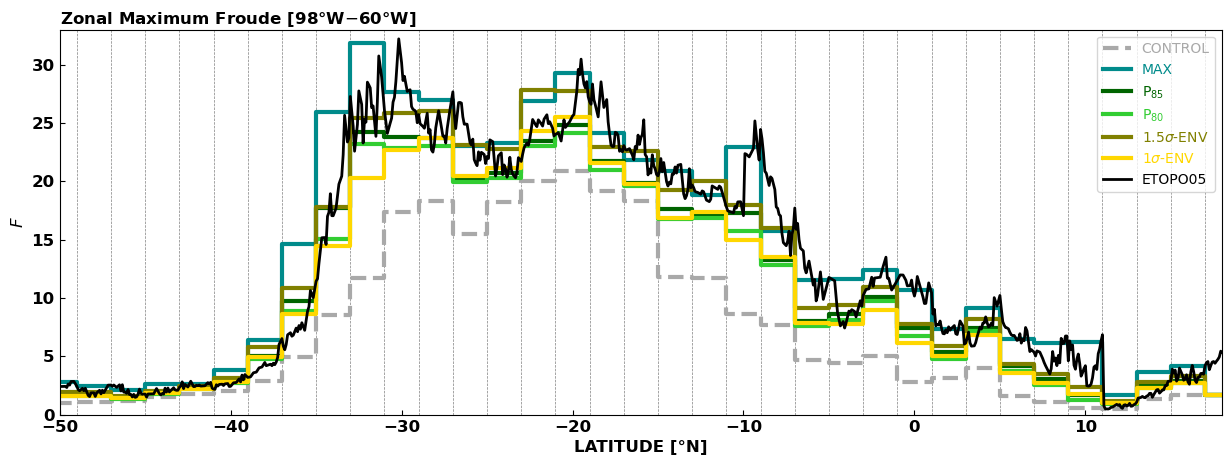

In [36]:
lat=frGiss_lowres_zm.lat
#colors=['darkgray','royalblue','deepskyblue','lightskyblue','powderblue','gold','brown']
#colors=['darkgray','firebrick','peru','gold','orangered','orchid','brown']
colors=['darkgray','darkcyan','darkgreen','limegreen','olive','gold']
tkw = {'axis': 'both', 'direction':'in', 'labelsize': 'large', 'labelcolor': 'k'}   
text_kw={'color':'k', 'weight':'bold', 'size':'large', 'ha':'center'}
arrow_kw={'color':'black', 'linewidth':.1, 'shrink':0.05}
line_kw={'lw':3, 'drawstyle':'steps-pre'} 
patch_kw = {'facecolor':'grey', 'alpha':0.25}
legend_kw={'fontsize':'medium',
          'labelcolor':'linecolor',
          'frameon':True}

fig=plt.figure(figsize=(15,5))

ax=plt.subplot2grid((1, 1), (0, 0), colspan=1, rowspan=1)
ax.text(-50, 33.5, 'Zonal Maximum Froude [98°W$-$60°W]', weight='bold', size='large', horizontalalignment='left')
# add arrows indicating locations of Central American wind gaps
ax.annotate('TH', xy=(15.8,4750), xytext=(15.8,5350), arrowprops=arrow_kw, **text_kw, label='_Hidden')
ax.annotate('PG', xy=(11.75,4750), xytext=(11.75,5350), arrowprops=arrow_kw, **text_kw, label='_Hidden')
ax.annotate('PA', xy=(8.1,4750), xytext=(8.1,5350), arrowprops=arrow_kw, **text_kw, label='_Hidden')
# plot model topo bcs
ax.plot(frGiss_lowres_zm.lat, frGiss_lowres_zm[0].mean(dim='month'), c=colors[0], ls='--', label=str(frGiss_lowres_zm[0].source_id.values), **line_kw)
for i in np.arange(1,6):
    ax.plot(frGiss_lowres_zm.lat, frGiss_lowres_zm[i].mean(dim='month'), c=colors[i], ls='-', label=str(frGiss_lowres_zm[i].source_id.values), **line_kw)
# plot etopo obs
ax.plot(frObs_zm.lat, frObs_zm.mean(dim='month'), c='k', lw=2, ls='-', label='ETOPO05')
# set axis info
ax.set(xlim=[-50, 18], ylim=[0,33])
#plt.yticks([1, 2, 3, 4, 5])
ax.set_xlabel('LATITUDE [°N]', **text_kw)
ax.set_ylabel('$F$', **text_kw)
ax.tick_params(**tkw)
plt.xticks(weight='bold')
plt.yticks(weight='bold')

for j in lat[1::1]:
    ax.axvline(x=j,  c='gray', lw=.5, ls='--', zorder=0)
    
#ax.axhline(y=2000, c='grey', lw=1, ls='-', zorder=0)
#pp=plt.Rectangle((-55, 2000), 80, 1000, label='_Hidden', zorder=1, **patch_kw) 
#ax.add_patch(pp)

ax.legend(loc=0, **legend_kw) 

#plt.savefig('figs/froude_cross_section.pdf', transparent=True, bbox_inches='tight')

In [22]:
temp=frObs_idx.mean(dim='month', skipna=True).interp_like(frGiss_lowres).max(dim='lon')
temp=temp.fillna(0)
frObs_lowres=temp

vec=np.flip(np.array([frObs_lowres]))
frObs_zm=vec.reshape(vec.shape[1], 1)

### all bcs, with heatmap

In [6]:
frGiss=frGiss.assign_coords(source_id=['CTRL', 'MAX', 'P$_{85}$', 'P$_{80}$', '1.5$\\sigma$-ENV','1$\\sigma$-ENV', '1$\\sigma$-ENV-CAM'])

In [9]:
## Load MERRA-2 winds
# lev: 0=1000hPa ; 6=850hPa
dpath=f'{dpath0}/obs_data/merra2'
um=xr.open_dataset(f'{dpath}/merra2.U.1980-2022.monthly.nc').U[:,6].groupby("time.month").mean() #u.full.merra2.climo.e2pt1_grid.nc').U[:,0]
vm=xr.open_dataset(f'{dpath}/merra2.V.1980-2022.monthly.nc').V[:,6].groupby("time.month").mean()

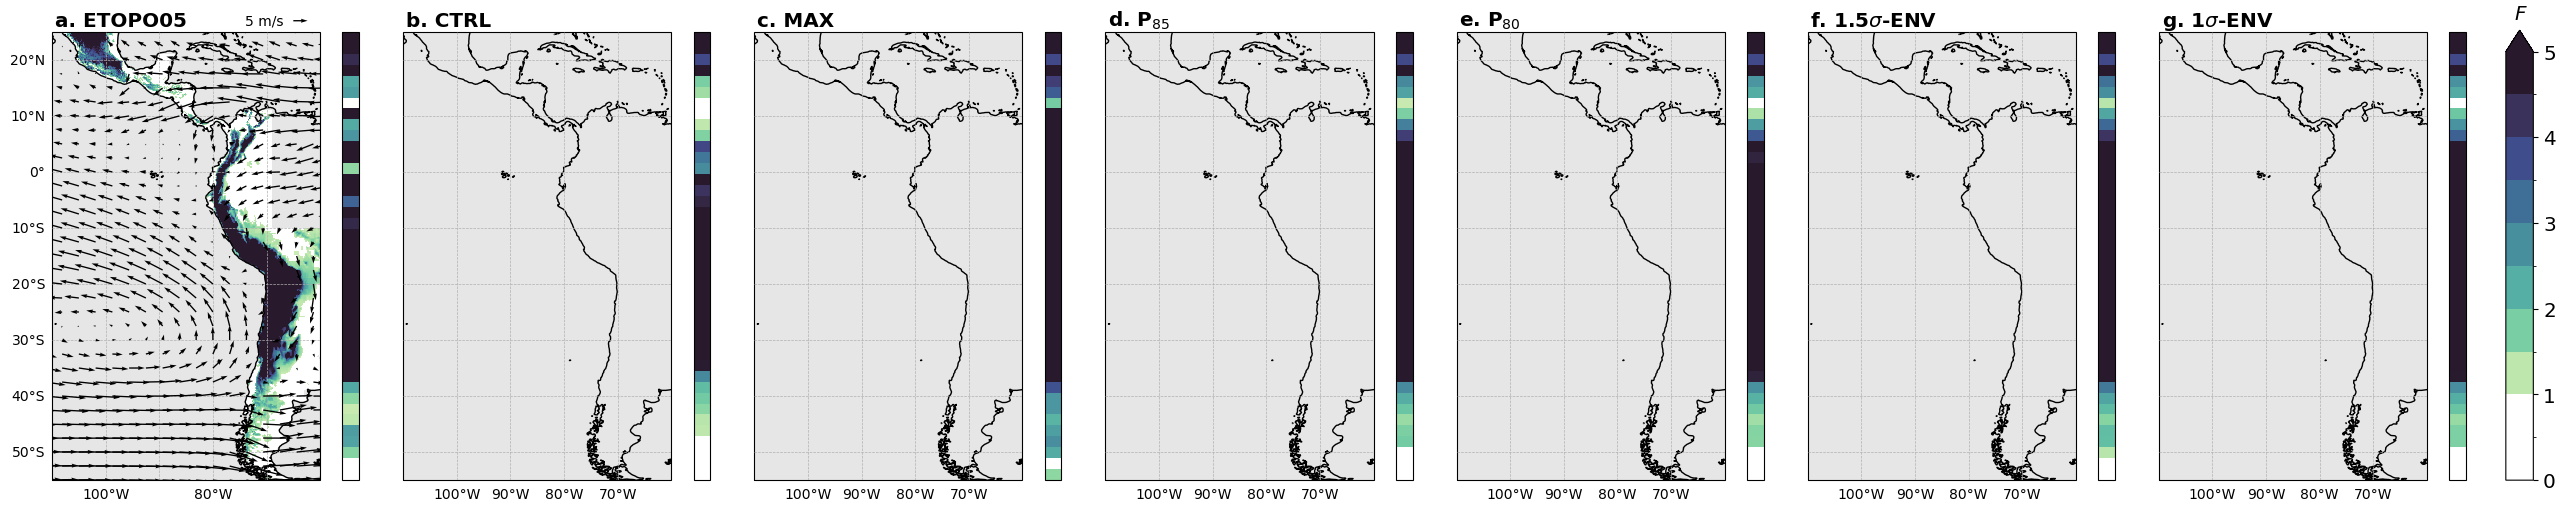

In [10]:
text_kw={'color':'k', 'weight':'bold', 'size':'x-large', 'horizontalalignment':'left'}
arr_text_kw={'color':'r', 'weight':'bold', 'size':'medium', 'horizontalalignment':'left', 'verticalalignment':'bottom'}
arrow_kw={'color':'red', 'linewidth':.01, 'shrink':0.0}
# cmap specs
tcmap=cmo.deep
newcolors=tcmap(np.linspace(0.1, 1, 200))
white=np.repeat(np.array([[1, 1, 1, 1],[1, 1, 1, 1]]),25, axis=0)
cmap=ListedColormap(np.vstack((white, newcolors)))
vmin=0
vmax=5
# vector specs
skip_n=5
w=0.003
scalef=35
key_length=5
# map specs
trans=ccrs.PlateCarree()
proj=ccrs.PlateCarree()
map_bnds=[-110,-60,-55,25]
titles=[]

fig, ax = plt.subplots(nrows=1, ncols=21, figsize=(25,5),
                       layout='constrained',
                       subplot_kw={'projection':proj},
                       gridspec_kw={'width_ratios': [3, 0.5, 0.15, 3, 0.5, 0.15, 3, 0.5, 0.15, 3, 0.5, 0.15, 3, 0.5, 0.15, 3, 0.5, 0.15, 3, 0.5, 0.15]}) #

ax[0].text(-109.5,26,'a. ETOPO05',**text_kw,zorder=100)
ax[0].pcolormesh(frObs_idx.lon, frObs_idx.lat, frObs.mean(dim='month'), cmap=cmap, vmin=vmin, vmax=vmax, transform=trans)
u=um.mean(dim='month')
v=vm.mean(dim='month')
q1=ax[0].quiver(u.lon[::skip_n], u.lat[::skip_n], u[::skip_n,::skip_n], v[::skip_n,::skip_n],
                 color='k', width=w, scale=scalef, scale_units='inches', units='height', transform=trans, zorder=100)
qk=ax[0].quiverkey(q1, .9, 1.025, key_length, rf'{key_length} m/s', labelcolor='k', labelpos='W')
#ax[0].annotate('TE', xy=(-94.25,18), xytext=(-95.25,23), label='_Hidden', arrowprops=arrow_kw, **arr_text_kw, zorder=10)
#ax[0].annotate('PG', xy=(-84,12.2), xytext=(-80,15.5), label='_Hidden', arrowprops=arrow_kw, **arr_text_kw, zorder=10)
#ax[0].annotate('PN', xy=(-79,9.5), xytext=(-76,13.5), label='_Hidden', arrowprops=arrow_kw, **arr_text_kw, zorder=10)
ax[0].set(aspect='auto')
ax[0].coastlines(color='k')
ax[0].add_feature(cfeature.OCEAN, fc=(0.9, 0.9, 0.9), zorder=0)
ax[0].add_feature(cfeature.LAND, fc=(0.9, 0.9, 0.9), zorder=0)
ax[0].set_extent(map_bnds, crs=trans)
gl=ax[0].gridlines(crs=trans, lw=.5, colors='black', alpha=1.0, linestyle='--', zorder=10, draw_labels=True)
gl.xlocator=mticker.FixedLocator([-100,-90,-80,-70])
gl.bottom_labels=True; gl.left_labels=True; gl.top_labels=False; gl.right_labels=False
gl.xformatter=LONGITUDE_FORMATTER
gl.yformatter=LATITUDE_FORMATTER
gl.xlabel_style={'color': 'black', 'weight': 'normal'}
gl.ylabel_style={'color': 'black', 'weight': 'normal'}
# heatmap
temp=frObs.mean(dim='month', skipna=True).interp_like(frGiss_lowres).max(dim='lon')
vec=np.flip(np.array([temp]))
#vec=np.flip(np.array([frObs.mean(dim='month').max(dim='lon')]))
frObs_zm=vec.reshape(vec.shape[1], 1)
sns.heatmap(frObs_zm, vmin=vmin, vmax=vmax, cmap=cmap, yticklabels=False, xticklabels=False, square=True, cbar=False, ax=ax[1])
ax[1].set(aspect=0.65)

ax[2].set_visible(False)
ax[5].set_visible(False)
ax[8].set_visible(False)
ax[11].set_visible(False)
ax[14].set_visible(False)
ax[17].set_visible(False)
ax[20].set_visible(False)

for i in [0,1,2,3,4,5]:
    axn=[3,6,9,12,15,18] #[2,4,6,8,10,12]
    n=axn[i]
    letter=['b. ','c. ','d. ','e. ','f. ','g. ', 'h. ', 'i. ']
    ax[n].text(-109.5,26,letter[i]+str(frGiss[i].source_id.values),**text_kw,zorder=100)
    # plot Froude map
    ax[n].pcolormesh(frGiss_idx.lon, frGiss_idx.lat, frGiss_lowres[i].mean(dim='month'), cmap=cmap, vmin=vmin, vmax=vmax, transform=trans)
    ax[n].set(aspect='auto')
    ax[n].coastlines(color='k')
    ax[n].add_feature(cfeature.OCEAN, fc=(0.9, 0.9, 0.9), zorder=0)
    ax[n].add_feature(cfeature.LAND, fc=(0.9, 0.9, 0.9), zorder=0)
    ax[n].set_extent(map_bnds, crs=trans)
    gl=ax[n].gridlines(crs=trans, lw=.5, colors='black', alpha=1.0, linestyle='--', zorder=10, draw_labels=True)
    gl.xlocator=mticker.FixedLocator([-100,-90,-80,-70])
    gl.bottom_labels=True; gl.left_labels=False; gl.top_labels=False; gl.right_labels=False
    gl.xformatter=LONGITUDE_FORMATTER
    gl.yformatter=LATITUDE_FORMATTER
    gl.xlabel_style={'color': 'black', 'weight': 'normal'}
    gl.ylabel_style={'color': 'black', 'weight': 'normal'}
    # plot max Froude heat map
    vec=np.flip(np.array([frGiss_lowres[i].mean(dim='month').max(dim='lon')]))
    frGiss_zm=vec.reshape(vec.shape[1], 1)
    sns.heatmap(frGiss_zm, vmin=vmin, vmax=vmax, cmap=cmap, yticklabels=False, xticklabels=False, square=True, cbar=False, ax=ax[n+1])
    ax[n+1].set(aspect=.65)

    
# add colorbar
levels=np.linspace(vmin, vmax, 11)
norm=mpl.colors.BoundaryNorm(levels, cmap.N)
cf=mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
cax=fig.add_axes([1, 0.05, 0.011, 0.9])
cbar=fig.colorbar(cf, orientation='vertical', extend='max', cax=cax)
cbar.set_label('$F$', y=1.11, labelpad=-25, rotation=0, size='x-large', fontweight='bold', ha='center')
cbar.ax.tick_params(labelsize='x-large')
for tick in cbar.ax.yaxis.get_major_ticks():
    tick.label2.set_fontweight('normal')

plt.savefig('figs/froude_max_heatmap_850winds.pdf', transparent=True, bbox_inches='tight')

### all bcs, 1 row

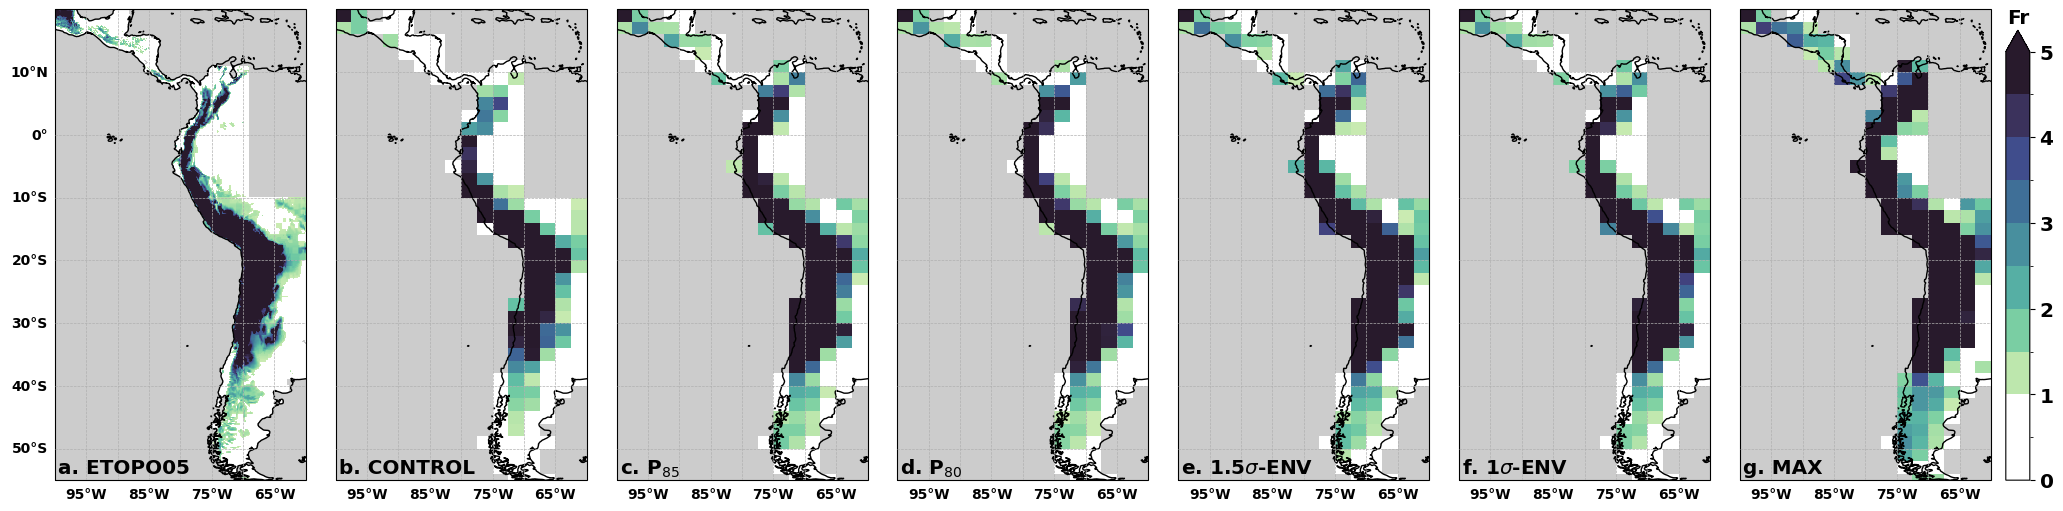

In [6]:
text_kw={'color':'k', 'weight':'bold', 'size':'x-large', 'horizontalalignment':'left'}
tcmap=cmo.deep
newcolors=tcmap(np.linspace(0.1, 1, 200))
white=np.repeat(np.array([[1, 1, 1, 1],[1, 1, 1, 1]]),25, axis=0)
cmap=ListedColormap(np.vstack((white, newcolors)))
"""
tcmap=cm.viridis_r#cmo.dense #magma
newcolors=tcmap(np.linspace(0, 1, 250))
black=np.array([1, 1, 1, 1])
newcolors[:50, :]=black
cmap=ListedColormap(newcolors)
"""
vmin=0
vmax=5
trans=ccrs.PlateCarree()
proj=ccrs.PlateCarree()
map_bnds=[-100,-60,-55,20]
titles=[]

fig, ax = plt.subplots(nrows=1, ncols=7, figsize=(20,5), layout='constrained', subplot_kw={'projection':proj})

ax[0].text(-99.5,-54,'a. ETOPO05',**text_kw,zorder=100)
ax[0].pcolormesh(frObs_idx.lon, frObs_idx.lat, frObs.mean(dim='month'), cmap=cmap, vmin=vmin, vmax=vmax, transform=trans)
    
ax[1].text(-99.5,-54,'b. '+str(frGiss[0].source_id.values),**text_kw,zorder=100)
ax[1].pcolormesh(frGiss_idx.lon, frGiss_idx.lat, frGiss_lowres[0].mean(dim='month'), cmap=cmap, vmin=vmin, vmax=vmax, transform=trans)

ax[2].text(-99.5,-54,'c. '+str(frGiss[2].source_id.values),**text_kw,zorder=100)
ax[2].pcolormesh(frGiss_idx.lon, frGiss_idx.lat, frGiss_lowres[2].mean(dim='month'), cmap=cmap, vmin=vmin, vmax=vmax, transform=trans)

ax[3].text(-99.5,-54,'d. '+str(frGiss[3].source_id.values),**text_kw,zorder=100)
ax[3].pcolormesh(frGiss_idx.lon, frGiss_idx.lat, frGiss_lowres[3].mean(dim='month'), cmap=cmap, vmin=vmin, vmax=vmax, transform=trans)

ax[4].text(-99.5,-54,'e. '+str(frGiss[4].source_id.values),**text_kw,zorder=100)
ax[4].pcolormesh(frGiss_idx.lon, frGiss_idx.lat, frGiss_lowres[4].mean(dim='month'), cmap=cmap, vmin=vmin, vmax=vmax, transform=trans)
    
ax[5].text(-99.5,-54,'f. '+str(frGiss[5].source_id.values),**text_kw,zorder=100)
ax[5].pcolormesh(frGiss_idx.lon, frGiss_idx.lat, frGiss_lowres[5].mean(dim='month'), cmap=cmap, vmin=vmin, vmax=vmax, transform=trans)

ax[6].text(-99.5,-54,'g. '+str(frGiss[1].source_id.values),**text_kw,zorder=100)
ax[6].pcolormesh(frGiss_idx.lon, frGiss_idx.lat, frGiss_lowres[1].mean(dim='month'), cmap=cmap, vmin=vmin, vmax=vmax, transform=trans)

for i, ax in enumerate(ax.flat): 
    ax.coastlines(color='k')
    ax.add_feature(cfeature.OCEAN, fc=(.8,.8,.8), zorder=0)
    ax.add_feature(cfeature.LAND, fc=(.8,.8,.8), zorder=0)
    ax.set_extent(map_bnds, crs=trans)
    if i==0:
        gl=ax.gridlines(crs=trans, lw=.5, colors='black', alpha=1.0, linestyle='--', zorder=10, draw_labels=True)
        gl.bottom_labels=True; gl.left_labels=True; gl.top_labels=False; gl.right_labels=False
    else:
        gl=ax.gridlines(crs=trans, lw=.5, colors='black', alpha=1.0, linestyle='--', zorder=10, draw_labels=True)
        gl.bottom_labels=True; gl.left_labels=False; gl.top_labels=False; gl.right_labels=False
    gl.xformatter=LONGITUDE_FORMATTER
    gl.yformatter=LATITUDE_FORMATTER
    gl.xlabel_style={'color': 'black', 'weight': 'bold'}
    gl.ylabel_style={'color': 'black', 'weight': 'bold'}

# add colorbar
levels=np.linspace(vmin, vmax, 11)
norm=mpl.colors.BoundaryNorm(levels, cmap.N)
cf=mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
cax=fig.add_axes([1, 0.05, 0.012, 0.9])
cbar=fig.colorbar(cf, orientation='vertical', extend='max', cax=cax)
cbar.set_label('Fr', y=1.1, labelpad=-25, rotation=0, size='x-large', fontweight='bold', ha='center')
cbar.ax.tick_params(labelsize='x-large')
for tick in cbar.ax.yaxis.get_major_ticks():
    tick.label2.set_fontweight('bold')
    
#plt.savefig('figs/froude_idx_green2.pdf', transparent=True, bbox_inches='tight')
#plt.savefig('figs/froude_idx_green2.svg', transparent=True, dpi='figure', format='svg', bbox_inches='tight')

### all bcs, separate Central and South America

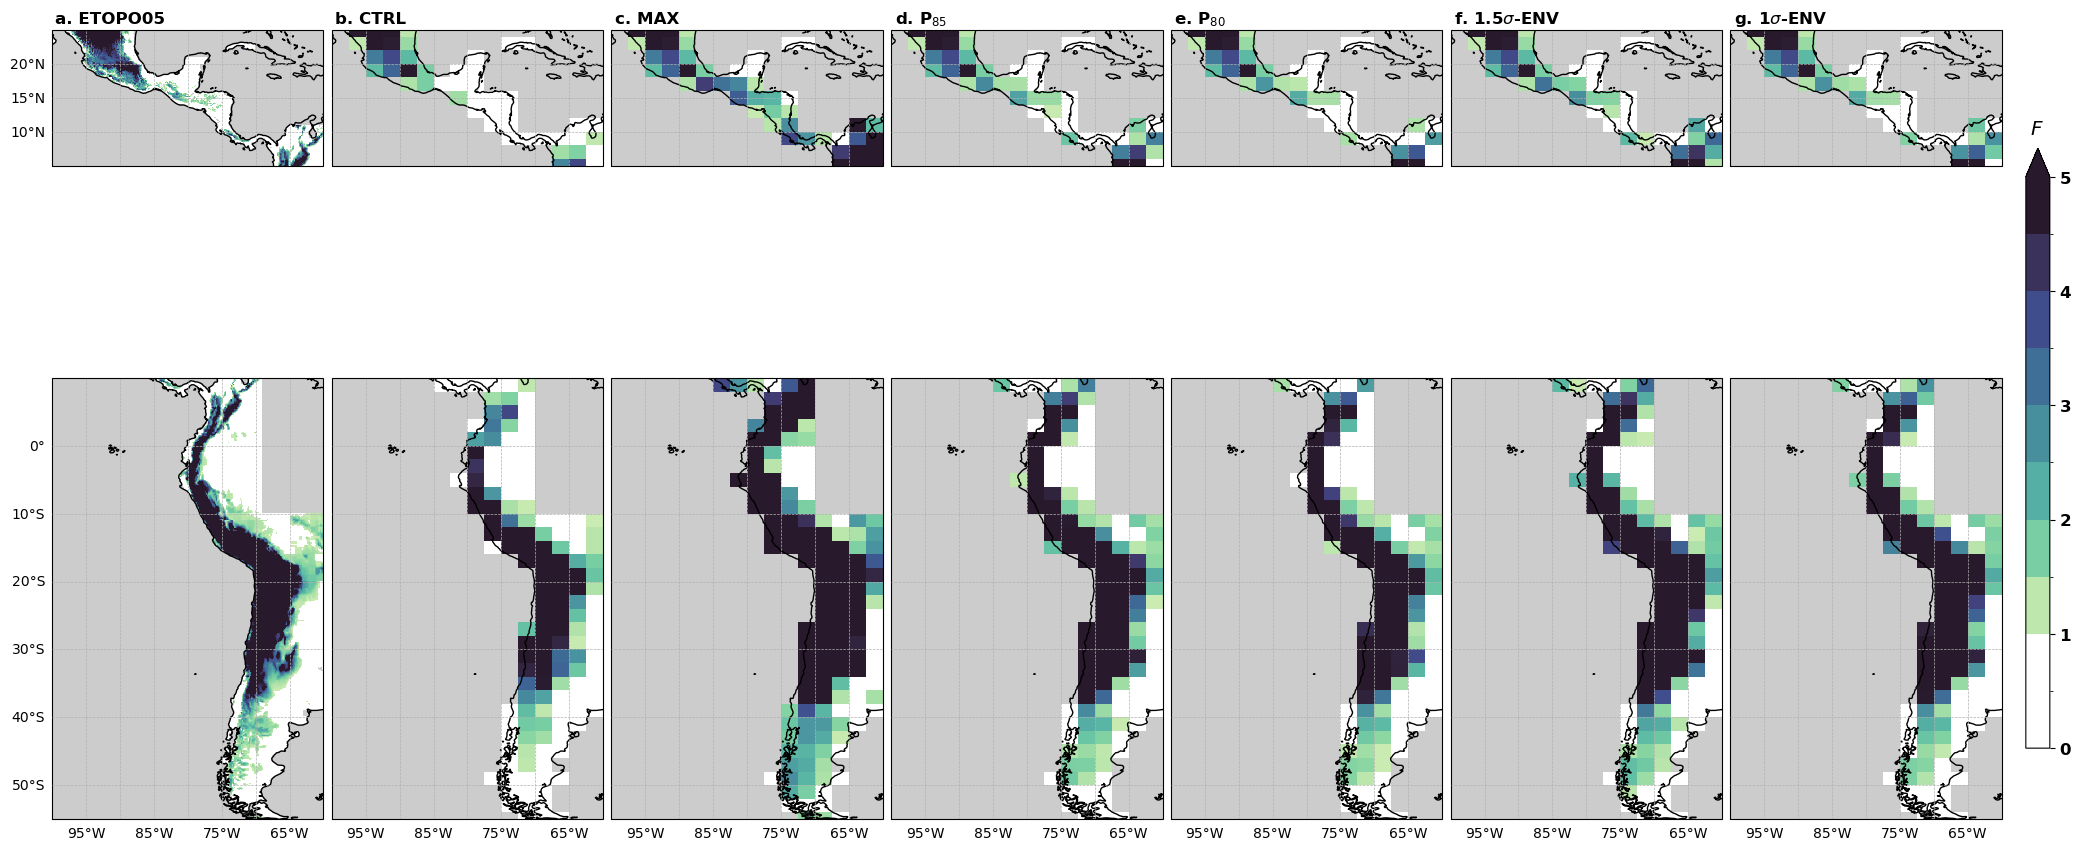

In [18]:
text_kw={'color':'k', 'weight':'bold', 'size':12, 'horizontalalignment':'left'}
tcmap=cmo.deep
newcolors=tcmap(np.linspace(0.1, 1, 200))
white=np.repeat(np.array([[1, 1, 1, 1],[1, 1, 1, 1]]),25, axis=0)
cmap=ListedColormap(np.vstack((white, newcolors)))
"""
tcmap=cm.viridis_r#cmo.dense #magma
newcolors=tcmap(np.linspace(0, 1, 250))
black=np.array([1, 1, 1, 1])
newcolors[:50, :]=black
cmap=ListedColormap(newcolors)
"""
vmin=0
vmax=5
trans=ccrs.PlateCarree()
proj=ccrs.PlateCarree()
map_bnds1=[-110,-70,5,25]
map_bnds2=[-100,-60,-55,10]
titles=[]

fig, ax = plt.subplots(nrows=2, ncols=7, figsize=(20,10), layout='constrained', subplot_kw={'projection':proj})

ax[0,0].text(-109.5,26,'a. ETOPO05',**text_kw,zorder=100)
ax[0,0].pcolormesh(frObs_idx.lon, frObs_idx.lat, frObs.mean(dim='month'), cmap=cmap, vmin=vmin, vmax=vmax, transform=trans)
ax[0,0].coastlines(color='k')
ax[0,0].add_feature(cfeature.OCEAN, fc=(.8,.8,.8), zorder=0)
ax[0,0].add_feature(cfeature.LAND, fc=(.8,.8,.8), zorder=0)
ax[0,0].set_extent(map_bnds1, crs=trans)
gl=ax[0,0].gridlines(crs=trans, lw=.5, colors='black', alpha=1.0, linestyle='--', zorder=10, draw_labels=True)
gl.ylocator=mticker.FixedLocator([5,10,15,20,25])
gl.bottom_labels=False; gl.left_labels=True; gl.top_labels=False; gl.right_labels=False
gl.xformatter=LONGITUDE_FORMATTER
gl.yformatter=LATITUDE_FORMATTER
gl.xlabel_style={'color': 'black', 'weight': 'normal'}
gl.ylabel_style={'color': 'black', 'weight': 'normal'}

ax[1,0].pcolormesh(frObs_idx.lon, frObs_idx.lat, frObs.mean(dim='month'), cmap=cmap, vmin=vmin, vmax=vmax, transform=trans)
ax[1,0].coastlines(color='k')
ax[1,0].add_feature(cfeature.OCEAN, fc=(.8,.8,.8), zorder=0)
ax[1,0].add_feature(cfeature.LAND, fc=(.8,.8,.8), zorder=0)
ax[1,0].set_extent(map_bnds2, crs=trans)
gl=ax[1,0].gridlines(crs=trans, lw=.5, colors='black', alpha=1.0, linestyle='--', zorder=10, draw_labels=True)
gl.bottom_labels=True; gl.left_labels=True; gl.top_labels=False; gl.right_labels=False
gl.xformatter=LONGITUDE_FORMATTER
gl.yformatter=LATITUDE_FORMATTER
gl.xlabel_style={'color': 'black', 'weight': 'normal'}
gl.ylabel_style={'color': 'black', 'weight': 'normal'}
    
    
for i in [0,1,2,3,4,5]:
    cols=[1,2,3,4,5,6]
    letter=['b. ','c. ','d. ','e. ','f. ','g. ']
    j=cols[i]
    
    # Central America
    if i==0:
        ax[0,1].text(-109.5,26,letter[i]+'CTRL',**text_kw,zorder=100)
    else:
        ax[0,j].text(-109.5,26,letter[i]+str(frGiss[i].source_id.values),**text_kw,zorder=100)
    ax[0,j].pcolormesh(frGiss_idx.lon, frGiss_idx.lat, frGiss_lowres[i].mean(dim='month'), cmap=cmap, vmin=vmin, vmax=vmax, transform=trans)
    ax[0,j].coastlines(color='k')
    ax[0,j].add_feature(cfeature.OCEAN, fc=(.8,.8,.8), zorder=0)
    ax[0,j].add_feature(cfeature.LAND, fc=(.8,.8,.8), zorder=0)
    ax[0,j].set_extent(map_bnds1, crs=trans)
    gl=ax[0,j].gridlines(crs=trans, lw=.5, colors='black', alpha=1.0, linestyle='--', zorder=10, draw_labels=True)
    gl.ylocator=mticker.FixedLocator([5,10,15,20,25])
    gl.bottom_labels=False; gl.left_labels=False; gl.top_labels=False; gl.right_labels=False
    gl.xformatter=LONGITUDE_FORMATTER
    gl.yformatter=LATITUDE_FORMATTER
    gl.xlabel_style={'color': 'black', 'weight': 'normal'}
    gl.ylabel_style={'color': 'black', 'weight': 'normal'}
    
    # South America
    ax[1,j].pcolormesh(frGiss_idx.lon, frGiss_idx.lat, frGiss_lowres[i].mean(dim='month'), cmap=cmap, vmin=vmin, vmax=vmax, transform=trans)
    ax[1,j].coastlines(color='k')
    ax[1,j].add_feature(cfeature.OCEAN, fc=(.8,.8,.8), zorder=0)
    ax[1,j].add_feature(cfeature.LAND, fc=(.8,.8,.8), zorder=0)
    ax[1,j].set_extent(map_bnds2, crs=trans)
    gl=ax[1,j].gridlines(crs=trans, lw=.5, colors='black', alpha=1.0, linestyle='--', zorder=10, draw_labels=True)
    gl.bottom_labels=True; gl.left_labels=False; gl.top_labels=False; gl.right_labels=False
    gl.xformatter=LONGITUDE_FORMATTER
    gl.yformatter=LATITUDE_FORMATTER
    gl.xlabel_style={'color': 'black', 'weight': 'normal'}
    gl.ylabel_style={'color': 'black', 'weight': 'normal'}


# add colorbar

levels=np.linspace(vmin, vmax, 11)
norm=mpl.colors.BoundaryNorm(levels, cmap.N)
cf=mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
cax=fig.add_axes([1.01, 0.1, 0.012, 0.6])
cbar=fig.colorbar(cf, orientation='vertical', extend='max', cax=cax)
cbar.set_label('$F$', y=1.1, labelpad=-25, rotation=0, size='x-large', fontweight='bold', ha='center')
cbar.ax.tick_params(labelsize='large')
for tick in cbar.ax.yaxis.get_major_ticks():
    tick.label2.set_fontweight('bold')

plt.savefig('figs/froude_ca_sa.pdf', transparent=True, bbox_inches='tight')
#plt.savefig('figs/froude_idx_green2.svg', transparent=True, dpi='figure', format='svg', bbox_inches='tight')

### all bcs, 2 rows

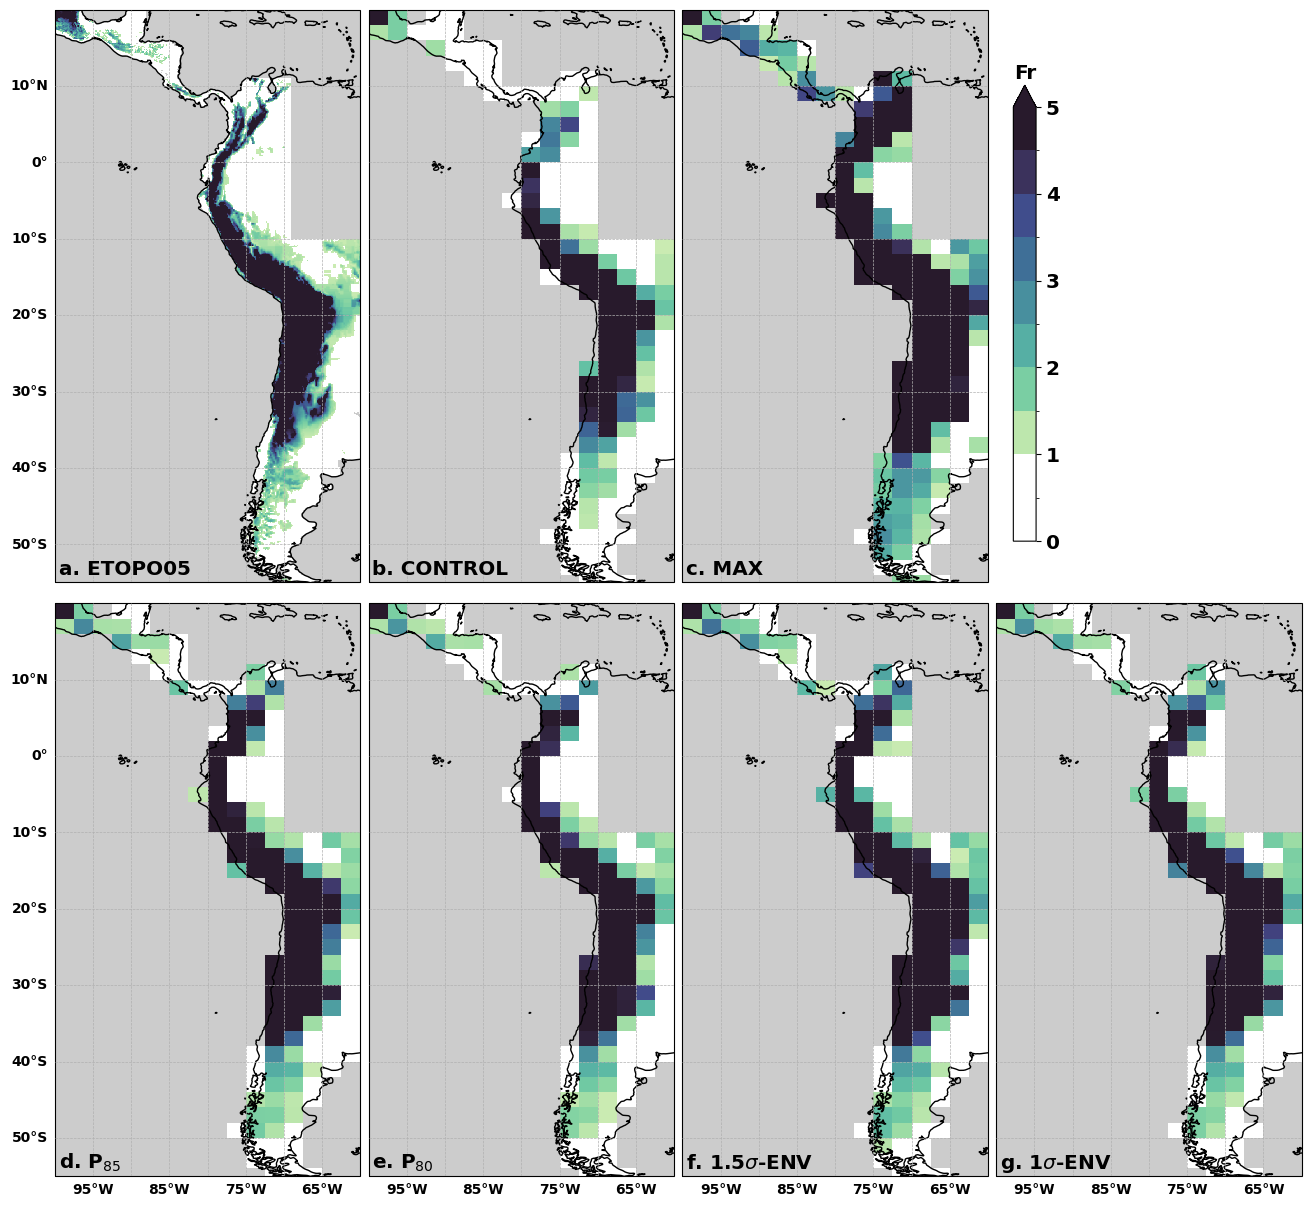

In [7]:
text_kw={'color':'k', 'weight':'bold', 'size':'x-large', 'horizontalalignment':'left'}
tcmap=cmo.deep
newcolors=tcmap(np.linspace(0.1, 1, 200))
white=np.repeat(np.array([[1, 1, 1, 1],[1, 1, 1, 1]]),25, axis=0)
cmap=ListedColormap(np.vstack((white, newcolors)))
"""
tcmap=cm.viridis_r#cmo.dense #magma
newcolors=tcmap(np.linspace(0, 1, 250))
black=np.array([1, 1, 1, 1])
newcolors[:50, :]=black
cmap=ListedColormap(newcolors)
"""
vmin=0
vmax=5
trans=ccrs.PlateCarree()
proj=ccrs.PlateCarree()
map_bnds=[-100,-60,-55,20]
titles=[]

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(13,12), layout='constrained', subplot_kw={'projection':proj})

ax[0,0].text(-99.5,-54,'a. ETOPO05',**text_kw,zorder=100)
ax[0,0].pcolormesh(frObs_idx.lon, frObs_idx.lat, frObs.mean(dim='month'), cmap=cmap, vmin=vmin, vmax=vmax, transform=trans)
    
ax[0,1].text(-99.5,-54,'b. '+str(frGiss[0].source_id.values),**text_kw,zorder=100)
ax[0,1].pcolormesh(frGiss_idx.lon, frGiss_idx.lat, frGiss_lowres[0].mean(dim='month'), cmap=cmap, vmin=vmin, vmax=vmax, transform=trans)

ax[0,2].text(-99.5,-54,'c. '+str(frGiss[1].source_id.values),**text_kw,zorder=100)
ax[0,2].pcolormesh(frGiss_idx.lon, frGiss_idx.lat, frGiss_lowres[1].mean(dim='month'), cmap=cmap, vmin=vmin, vmax=vmax, transform=trans)

ax[0,3].set_visible(False)

ax[1,0].text(-99.5,-54,'d. '+str(frGiss[2].source_id.values),**text_kw,zorder=100)
ax[1,0].pcolormesh(frGiss_idx.lon, frGiss_idx.lat, frGiss_lowres[2].mean(dim='month'), cmap=cmap, vmin=vmin, vmax=vmax, transform=trans)

ax[1,1].text(-99.5,-54,'e. '+str(frGiss[3].source_id.values),**text_kw,zorder=100)
ax[1,1].pcolormesh(frGiss_idx.lon, frGiss_idx.lat, frGiss_lowres[3].mean(dim='month'), cmap=cmap, vmin=vmin, vmax=vmax, transform=trans)

ax[1,2].text(-99.5,-54,'f. '+str(frGiss[4].source_id.values),**text_kw,zorder=100)
ax[1,2].pcolormesh(frGiss_idx.lon, frGiss_idx.lat, frGiss_lowres[4].mean(dim='month'), cmap=cmap, vmin=vmin, vmax=vmax, transform=trans)
    
ax[1,3].text(-99.5,-54,'g. '+str(frGiss[5].source_id.values),**text_kw,zorder=100)
ax[1,3].pcolormesh(frGiss_idx.lon, frGiss_idx.lat, frGiss_lowres[5].mean(dim='month'), cmap=cmap, vmin=vmin, vmax=vmax, transform=trans)

for i, ax in enumerate(ax.flat): 
    ax.coastlines(color='k')
    ax.add_feature(cfeature.OCEAN, fc=(.8,.8,.8), zorder=0)
    ax.add_feature(cfeature.LAND, fc=(.8,.8,.8), zorder=0)
    ax.set_extent(map_bnds, crs=trans)
    if i==0:
        gl=ax.gridlines(crs=trans, lw=.5, colors='black', alpha=1.0, linestyle='--', zorder=10, draw_labels=True)
        gl.bottom_labels=False; gl.left_labels=True; gl.top_labels=False; gl.right_labels=False
    elif i==4:
        gl=ax.gridlines(crs=trans, lw=.5, colors='black', alpha=1.0, linestyle='--', zorder=10, draw_labels=True)
        gl.bottom_labels=True; gl.left_labels=True; gl.top_labels=False; gl.right_labels=False
    elif i>4:
        gl=ax.gridlines(crs=trans, lw=.5, colors='black', alpha=1.0, linestyle='--', zorder=10, draw_labels=True)
        gl.bottom_labels=True; gl.left_labels=False; gl.top_labels=False; gl.right_labels=False
    else:
        ax.gridlines(crs=trans, lw=.5, colors='black', alpha=1.0, linestyle='--', zorder=10, draw_labels=False)
    gl.xformatter=LONGITUDE_FORMATTER
    gl.yformatter=LATITUDE_FORMATTER
    gl.xlabel_style={'color': 'black', 'weight': 'bold'}
    gl.ylabel_style={'color': 'black', 'weight': 'bold'}

# add colorbar
levels=np.linspace(vmin, vmax, 11)
norm=mpl.colors.BoundaryNorm(levels, cmap.N)
cf=mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
cax=fig.add_axes([0.775, 0.55, 0.0175, 0.38])
cbar=fig.colorbar(cf, orientation='vertical', extend='max', cax=cax)
cbar.set_label('Fr', y=1.1, labelpad=-25, rotation=0, size='x-large', fontweight='bold', ha='center')
cbar.ax.tick_params(labelsize='x-large')
for tick in cbar.ax.yaxis.get_major_ticks():
    tick.label2.set_fontweight('bold')
    
#plt.savefig('figs/froude_idx_green.pdf', transparent=True, bbox_inches='tight')
#plt.savefig('figs/froude_idx_purple', transparent=True, dpi='figure', format='svg', bbox_inches='tight')

### ctrl, 1senv, max only, 1 row

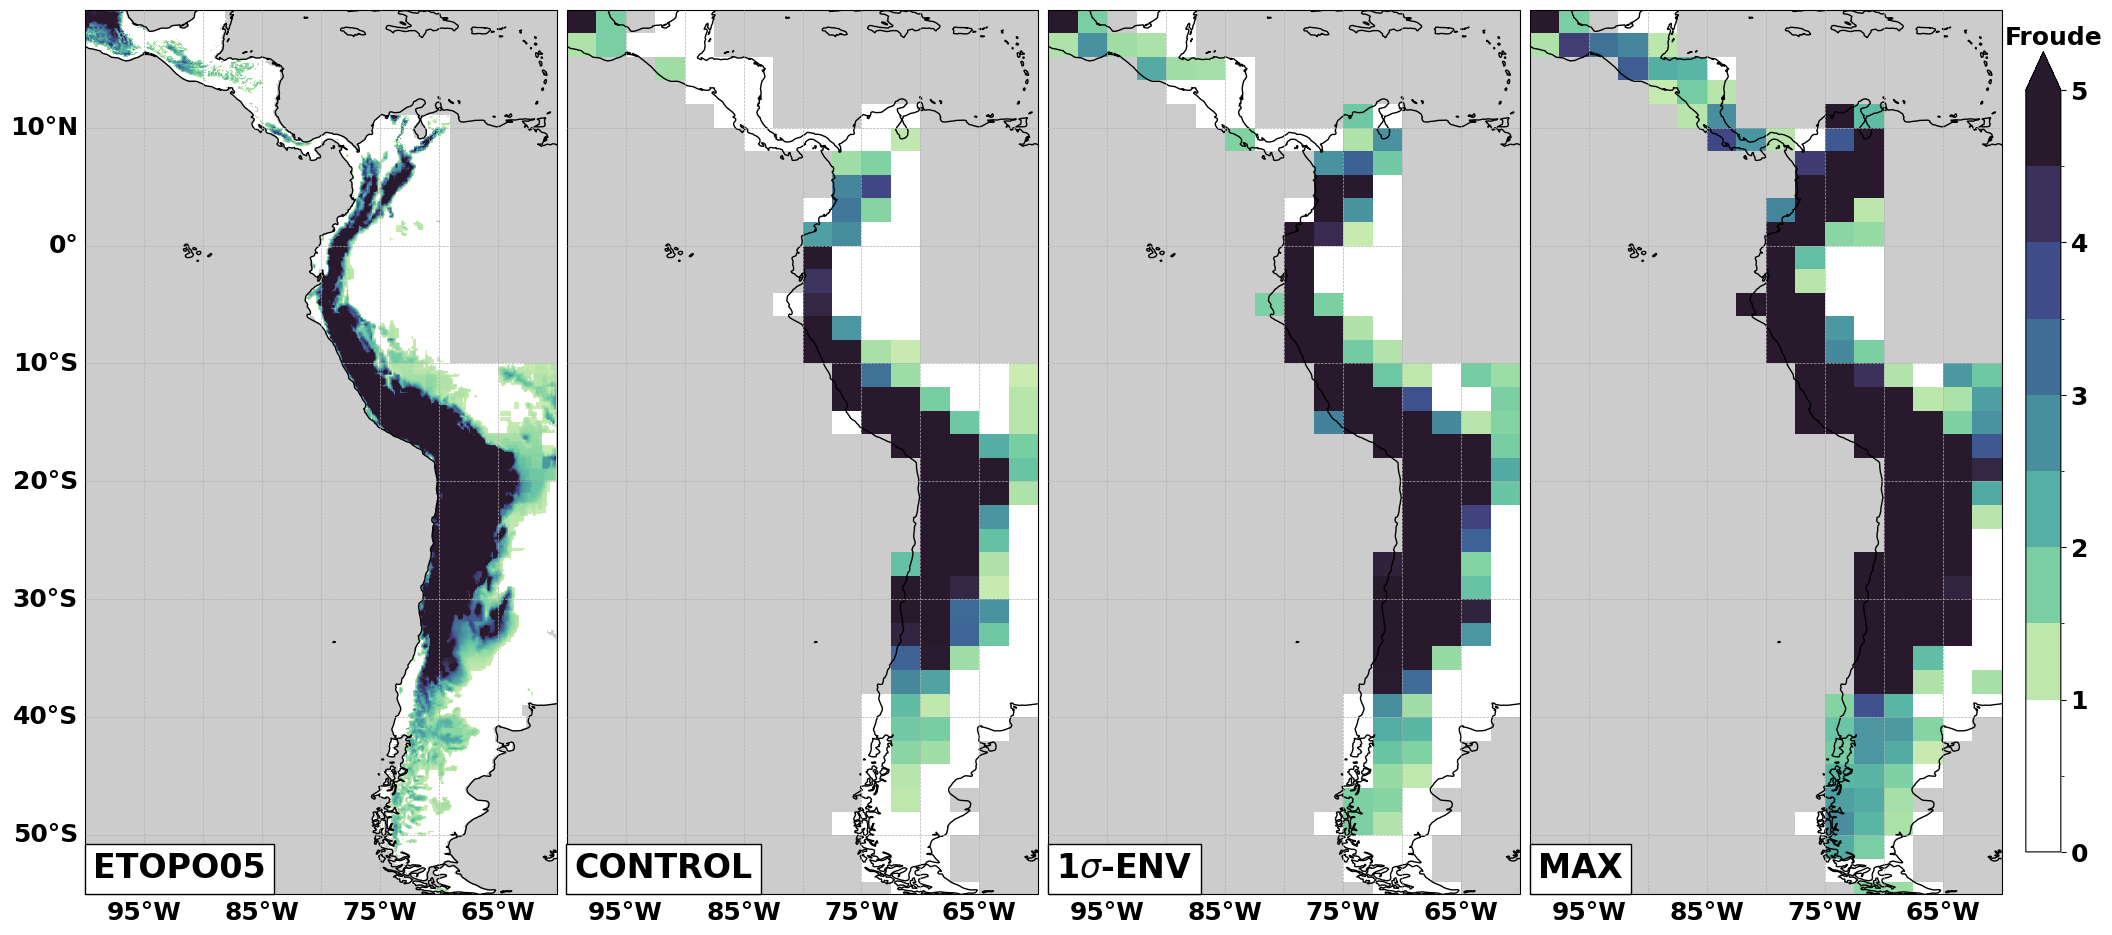

In [25]:
text_kw={'color':'k', 'weight':'bold', 'size':24, 'horizontalalignment':'left', 'verticalalignment':'bottom'}
bbox={'boxstyle':'square', 'fc':'w', 'ec':'black', 'alpha':1, 'pad':.25}
tcmap=cmo.deep
newcolors=tcmap(np.linspace(0.1, 1, 200))
white=np.repeat(np.array([[1, 1, 1, 1],[1, 1, 1, 1]]),25, axis=0)
cmap=ListedColormap(np.vstack((white, newcolors)))
"""
tcmap=cm.viridis_r#cmo.dense #magma
newcolors=tcmap(np.linspace(0, 1, 250))
black=np.array([1, 1, 1, 1])
newcolors[:50, :]=black
cmap=ListedColormap(newcolors)
"""
vmin=0
vmax=5
trans=ccrs.PlateCarree()
proj=ccrs.PlateCarree()
map_bnds=[-100,-60,-55,20]
titles=[]

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20,10), layout='constrained', subplot_kw={'projection':proj})

#ax[0].text(-99.5,-54,'ETOPO05',**text_kw,zorder=100)
ax[0].annotate('ETOPO05', xy=(0.017,0.01), xycoords='axes fraction', bbox=bbox, **text_kw, zorder=1000)
ax[0].pcolormesh(frObs_idx.lon, frObs_idx.lat, frObs.mean(dim='month'), cmap=cmap, vmin=vmin, vmax=vmax, transform=trans)
    
#ax[1].text(-99.5,-54, str(frGiss[0].source_id.values),**text_kw,zorder=100)
ax[1].annotate(str(frGiss[0].source_id.values), xy=(0.017,0.01), xycoords='axes fraction', bbox=bbox, **text_kw, zorder=1000)
ax[1].pcolormesh(frGiss_idx.lon, frGiss_idx.lat, frGiss_lowres[0].mean(dim='month'), cmap=cmap, vmin=vmin, vmax=vmax, transform=trans)

#ax[2].text(-99.5,-54, str(frGiss[5].source_id.values),**text_kw,zorder=100)
ax[2].annotate(str(frGiss[5].source_id.values), xy=(0.017,0.01), xycoords='axes fraction', bbox=bbox, **text_kw, zorder=1000)
ax[2].pcolormesh(frGiss_idx.lon, frGiss_idx.lat, frGiss_lowres[5].mean(dim='month'), cmap=cmap, vmin=vmin, vmax=vmax, transform=trans)

#ax[3].text(-99.5,-54, str(frGiss[1].source_id.values),**text_kw,zorder=100)
ax[3].annotate(str(frGiss[1].source_id.values), xy=(0.017,0.01), xycoords='axes fraction', bbox=bbox, **text_kw, zorder=1000)
ax[3].pcolormesh(frGiss_idx.lon, frGiss_idx.lat, frGiss_lowres[1].mean(dim='month'), cmap=cmap, vmin=vmin, vmax=vmax, transform=trans)

for i, ax in enumerate(ax.flat): 
    ax.coastlines(color='k')
    ax.add_feature(cfeature.OCEAN, fc=(.8,.8,.8), zorder=0)
    ax.add_feature(cfeature.LAND, fc=(.8,.8,.8), zorder=0)
    ax.set_extent(map_bnds, crs=trans)
    if i==0:
        gl=ax.gridlines(crs=trans, lw=.5, colors='black', alpha=1.0, linestyle='--', zorder=10, draw_labels=True)
        gl.bottom_labels=True; gl.left_labels=True; gl.top_labels=False; gl.right_labels=False
    else:
        gl=ax.gridlines(crs=trans, lw=.5, colors='black', alpha=1.0, linestyle='--', zorder=10, draw_labels=True)
        gl.bottom_labels=True; gl.left_labels=False; gl.top_labels=False; gl.right_labels=False
    gl.xformatter=LONGITUDE_FORMATTER
    gl.yformatter=LATITUDE_FORMATTER
    gl.xlabel_style={'color': 'black', 'weight': 'bold', 'size':18}
    gl.ylabel_style={'color': 'black', 'weight': 'bold', 'size':18}

# add colorbar
levels=np.linspace(vmin, vmax, 11)
norm=mpl.colors.BoundaryNorm(levels, cmap.N)
cf=mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
cax=fig.add_axes([1.01, 0.1, 0.0175, 0.8])
cbar=fig.colorbar(cf, orientation='vertical', extend='max', cax=cax)
cbar.set_label('Froude', y=1.085, labelpad=-25, rotation=0, size=18, fontweight='bold', ha='center')
cbar.ax.tick_params(labelsize=18)
for tick in cbar.ax.yaxis.get_major_ticks():
    tick.label2.set_fontweight('bold')
    
plt.savefig('figs/froude_idx_green.v3.pdf', transparent=True, bbox_inches='tight')
plt.savefig('figs/froude_idx_green.v3.svg', transparent=True, dpi='figure', format='svg', bbox_inches='tight')

# extract upstream data from individual MERRA-2 var files and store in NC

Disaggregating the data to the ETOPO05 grid is much easier for monthly climatologies rather than full timeseries of MERRA-2 data (12 timesteps vs. 516). 

In [ ]:
### ------------------------------- ###
###  Calculate Upstream Conditions  ###
### ------------------------------- ###

# TS is a 2D variable, don't need to slice levels
ts=xr.open_dataset(f'{dpath0}/obs_data/merra2.TS.1980-2022.monthly.nc').TS
ts_clip=ts.sel(lat=slice(lat_min,lat_max), lon=slice(lon_min,lon_max))#.groupby("time.month").mean()
ts_etopo_grid=ts_clip.interp(lat=etopo_clip.lat, lon=etopo_clip.lon)

ta=xr.open_dataset(f'{dpath0}/obs_data/merra2.T.1980-2022.monthly.nc').T
ta_clip=ta.sel(lat=slice(lat_min,lat_max), lon=slice(lon_min,lon_max), lev=slice(p1,p2))#.groupby("time.month").mean() 
ta_etopo_grid=ta_clip.interp(lat=etopo_clip.lat, lon=etopo_clip.lon)

h=xr.open_dataset(f'{dpath0}/obs_data/merra2.H.1980-2022.monthly.nc').H
h_clip=h.sel(lat=slice(lat_min,lat_max), lon=slice(lon_min,lon_max), lev=slice(p1,p2))#.groupby("time.month").mean() 
h_etopo_grid=h_clip.interp(lat=etopo_clip.lat, lon=etopo_clip.lon)

u=xr.open_dataset(f'{dpath0}/obs_data/merra2.U.1980-2022.monthly.nc').U
u_clip=u.sel(lat=slice(lat_min,lat_max), lon=slice(lon_min,lon_max), lev=slice(p1,p2))#.groupby("time.month").mean() 
u_etopo_grid=u_clip.interp(lat=etopo_clip.lat, lon=etopo_clip.lon)

v=xr.open_dataset(f'{dpath0}/obs_data/merra2.V.1980-2022.monthly.nc').V
v_clip=v.sel(lat=slice(lat_min,lat_max), lon=slice(lon_min,lon_max), lev=slice(p1,p2))#.groupby("time.month").mean() 
v_etopo_grid=v_clip.interp(lat=etopo_clip.lat, lon=etopo_clip.lon)
        
month=ta_etopo_grid.month
#time=ta_etopo_grid.time
lev=ta_etopo_grid.lev
lat=ta_etopo_grid.lat
lon=ta_etopo_grid.lon

frvars=xr.Dataset(data_vars=dict(ts=(['month','lat','lon'], ts_etopo_grid.data, ts_etopo_grid.attrs),
                                 ta=(['month','lev','lat','lon'], ta_etopo_grid.data, ta_etopo_grid.attrs),
                                 h=(['month','lev','lat','lon'], h_etopo_grid.data, h_etopo_grid.attrs),
                                 u=(['month','lev','lat','lon'], u_etopo_grid.data, u_etopo_grid.attrs),
                                 v=(['month','lev','lat','lon'], v_etopo_grid.data, v_etopo_grid.attrs),),
                  coords=dict(month=month,lev=lev,lat=lat,lon=lon,),)
frvars.to_netcdf(f'{dpath0}/obs_data/frvars.climo.nc', mode='w')
"""
frvars=xr.Dataset(data_vars=dict(ts=(['time','lat','lon'], ts_etopo_grid.data, ts_etopo_grid.attrs),
                                 ta=(['time','lev','lat','lon'], ta_etopo_grid.data, ta_etopo_grid.attrs),
                                 h=(['time','lev','lat','lon'], h_etopo_grid.data, h_etopo_grid.attrs),
                                 u=(['time','lev','lat','lon'], u_etopo_grid.data, u_etopo_grid.attrs),
                                 v=(['time','lev','lat','lon'], v_etopo_grid.data, v_etopo_grid.attrs),),
                  coords=dict(month=month,lev=lev,lat=lat,lon=lon,),)
frvars.to_netcdf(f'{dpath0}/obs_data/frvars.tseries.nc', mode='w')
"""

# old

In [ ]:
### ------------------------------- ###
###        Calculate Froude         ###
### ------------------------------- ###

## Define Lat/Lon bounds for topo areas
lats_topo=np.array([[-55,-30],[-29.99,-10],[-9.99,11],[11.01,25]])
lons_topo=np.array([[-80,-60],[-80,-60],[-85,-69],[-110,-80]])

## Define Lat/Lon bounds for upstream vars
lats_ups=np.array([[-55,-30],[-29.99,-10],[-9.99,11],[11.01,25]])
lons_ups=np.array([[-95,-90],[-55,-50],[-65,-60],[-75,-70]])

## Define pressure level thresholds for wind and N vars
surface_plev=1000
wind_p2lev=800
wind_p2idx=np.where(frvars.lev==wind_p2lev)
n_p2lev=600
n_p2idx=np.where(frvars.lev==n_p2lev)


for i in [0, 1, 2, 3]:
    ## Clip topo data to corresponding lat/lon bounds
    print('Clipping topography...')
    tymin=lats_topo[i,0] ; tymax=lats_topo[i,1]
    txmin=lons_topo[i,0] ; txmax=lons_topo[i,1]
    h=etopo_full.sel(lat=slice(tymin,tymax), lon=slice(txmin,txmax))
    
    ## Clip upstream climate data and calculate zonal regional means
    print('Calculating Zonal Mean Upstream N and Uspd...')
    ymin=lats_ups[i,0] ; ymax=lats_ups[i,1]
    xmin=lons_ups[i,0] ; xmax=lons_ups[i,1]
    # Wind Speed
    uwnd=frvars.u[:,0:wind_p2idx,:,:].sel(lat=slice(ymin,ymax), lon=slice(xmin,xmax))
    vwnd=frvars.v[:,0:wind_p2idx,:,:].sel(lat=slice(ymin,ymax), lon=slice(xmin,xmax))
    Uspd=windSpd(uwnd,vwnd).mean(dim=['lev','lon'])
    # Buoyancy Frequency
    t0=frvars.ts.sel(lat=slice(ymin,ymax), lon=slice(xmin,xmax))
    t1=frvars.ta[:,n_p2idx,:,:].sel(lat=slice(ymin,ymax), lon=slice(xmin,xmax))
    z0=etopo_full.sel(lat=slice(ymin,ymax), lon=slice(xmin,xmax)) # get surface height from etopo dataset
    z1=frvars.h[:,n_p2idx,:,:].sel(lat=slice(ymin,ymax), lon=slice(xmin,xmax)) # height of atm at plevel
    g=np.full((len(t0.lat),len(t0.lon)), 9.81) # gravity
    theta=t1*((surface_plev/p1)**(2/7))
    dtdz=(t1-t0)/(z1-z0)
    dthetadz=((surface_plev/p1)**(2/7)) * (.00976 - np.abs(dtdz))
    N=np.sqrt((g/theta)*dthetadz).mean(dim='lon',skipna=True)
    
    ## Calculate Froude
    print('Calculating Froude...')
    Fr=froude(N,h,Uspd)